In [2]:
%%capture
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install seaborn

##  Задание 3. LogReg.

### task1

**Формулировка:** Используя функцию make_blobs с любым random_state, сгенерировать датасет df, в
котором есть три класса с размером каждого класса 100 объектов и восемь
количественных (недискретных) признаков, при этом центры классов зафиксированы в
следующих точках: 
- Класс 0 – (+1,+1,+1,+1,+1,+1,+1,+1), 
- Класс 1 – (-1,-1,-1,-1,-1,-1,-1,-1),
- Класс 2 – (+1,-1,+1,-1,+1,-1,+1,-1).

(***Не забываем повторять шаги задания 1 task1***:
- ключевые характеристики датасета
- корреляции
- визуализация на всех парах переменных)

In [3]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs

In [4]:
np.random.seed(42)

In [5]:
cluster_centers = [np.ones(8) for i in range(3)]
cluster_centers[1] = - cluster_centers[1]
cluster_centers[2] = np.array([x if idx%2==0 else -x for idx,x in enumerate(cluster_centers[2])])
cluster_centers

[array([1., 1., 1., 1., 1., 1., 1., 1.]),
 array([-1., -1., -1., -1., -1., -1., -1., -1.]),
 array([ 1., -1.,  1., -1.,  1., -1.,  1., -1.])]

In [6]:
X, y = make_blobs(n_samples=300,
                  n_features=8,
                  cluster_std=0.5,
                  centers=cluster_centers,
                  random_state=42)

In [7]:
print(type(X),X.shape)
print(type(y),y.shape)

<class 'numpy.ndarray'> (300, 8)
<class 'numpy.ndarray'> (300,)


In [8]:
y_column = y.reshape((300,1))

In [9]:
df = pd.DataFrame(data=np.concatenate((X, y_column), axis=1), columns=[f"x{i}" for i in range(8)] + ["cluster_id"])

In [10]:
df.head()

x0        x1        x2        x3        x4        x5        x6  \
0 -0.163714 -0.790490 -1.352506 -1.027885 -0.720837 -0.961997 -0.730622   
1 -1.010684 -1.373606 -2.212120 -0.557977 -0.631578 -1.140664 -0.966505   
2  1.084230 -0.341201  0.496729 -0.430061  1.658558 -1.059034 -0.060927   
3  0.499834 -1.338872  1.256954 -0.910209  1.175315 -0.755406  1.317361   
4  1.583891  1.127210  1.168801  0.794062  0.756197  0.783721  1.197226   

         x7  cluster_id  
0 -1.460337         1.0  
1 -0.742030         1.0  
2 -1.303911         2.0  
3 -0.445150         2.0  
4  0.789508         0.0

In [11]:
stats = {}

stats["Number of features"] = 8
stats["Number of target classes"] = 3
stats["Number of object in each class"] = dict(df['cluster_id'].value_counts())
stats['Dataset dimensionality'] = f"{df.shape[0]} * {df.shape[1]}"
stats['% of missing values'] = f"{(df.isna().sum().sum() / df.size * 100):.2f}%"

stat_table = pd.DataFrame({
    'Parameter': [
        'Dataset dimensionality',
        'Number of features', 
        'Number of target classes',
        'Number of object in each class',
        '% of missing values',
    ],
    'Meaning': [
        stats['Dataset dimensionality'],
        stats['Number of features'],
        stats['Number of target classes'],
        stats['Number of object in each class'],
        stats['% of missing values'],
    ]
})
stat_table

Parameter                         Meaning
0          Dataset dimensionality                         300 * 9
1              Number of features                               8
2        Number of target classes                               3
3  Number of object in each class  {1.0: 100, 2.0: 100, 0.0: 100}
4             % of missing values                           0.00%

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

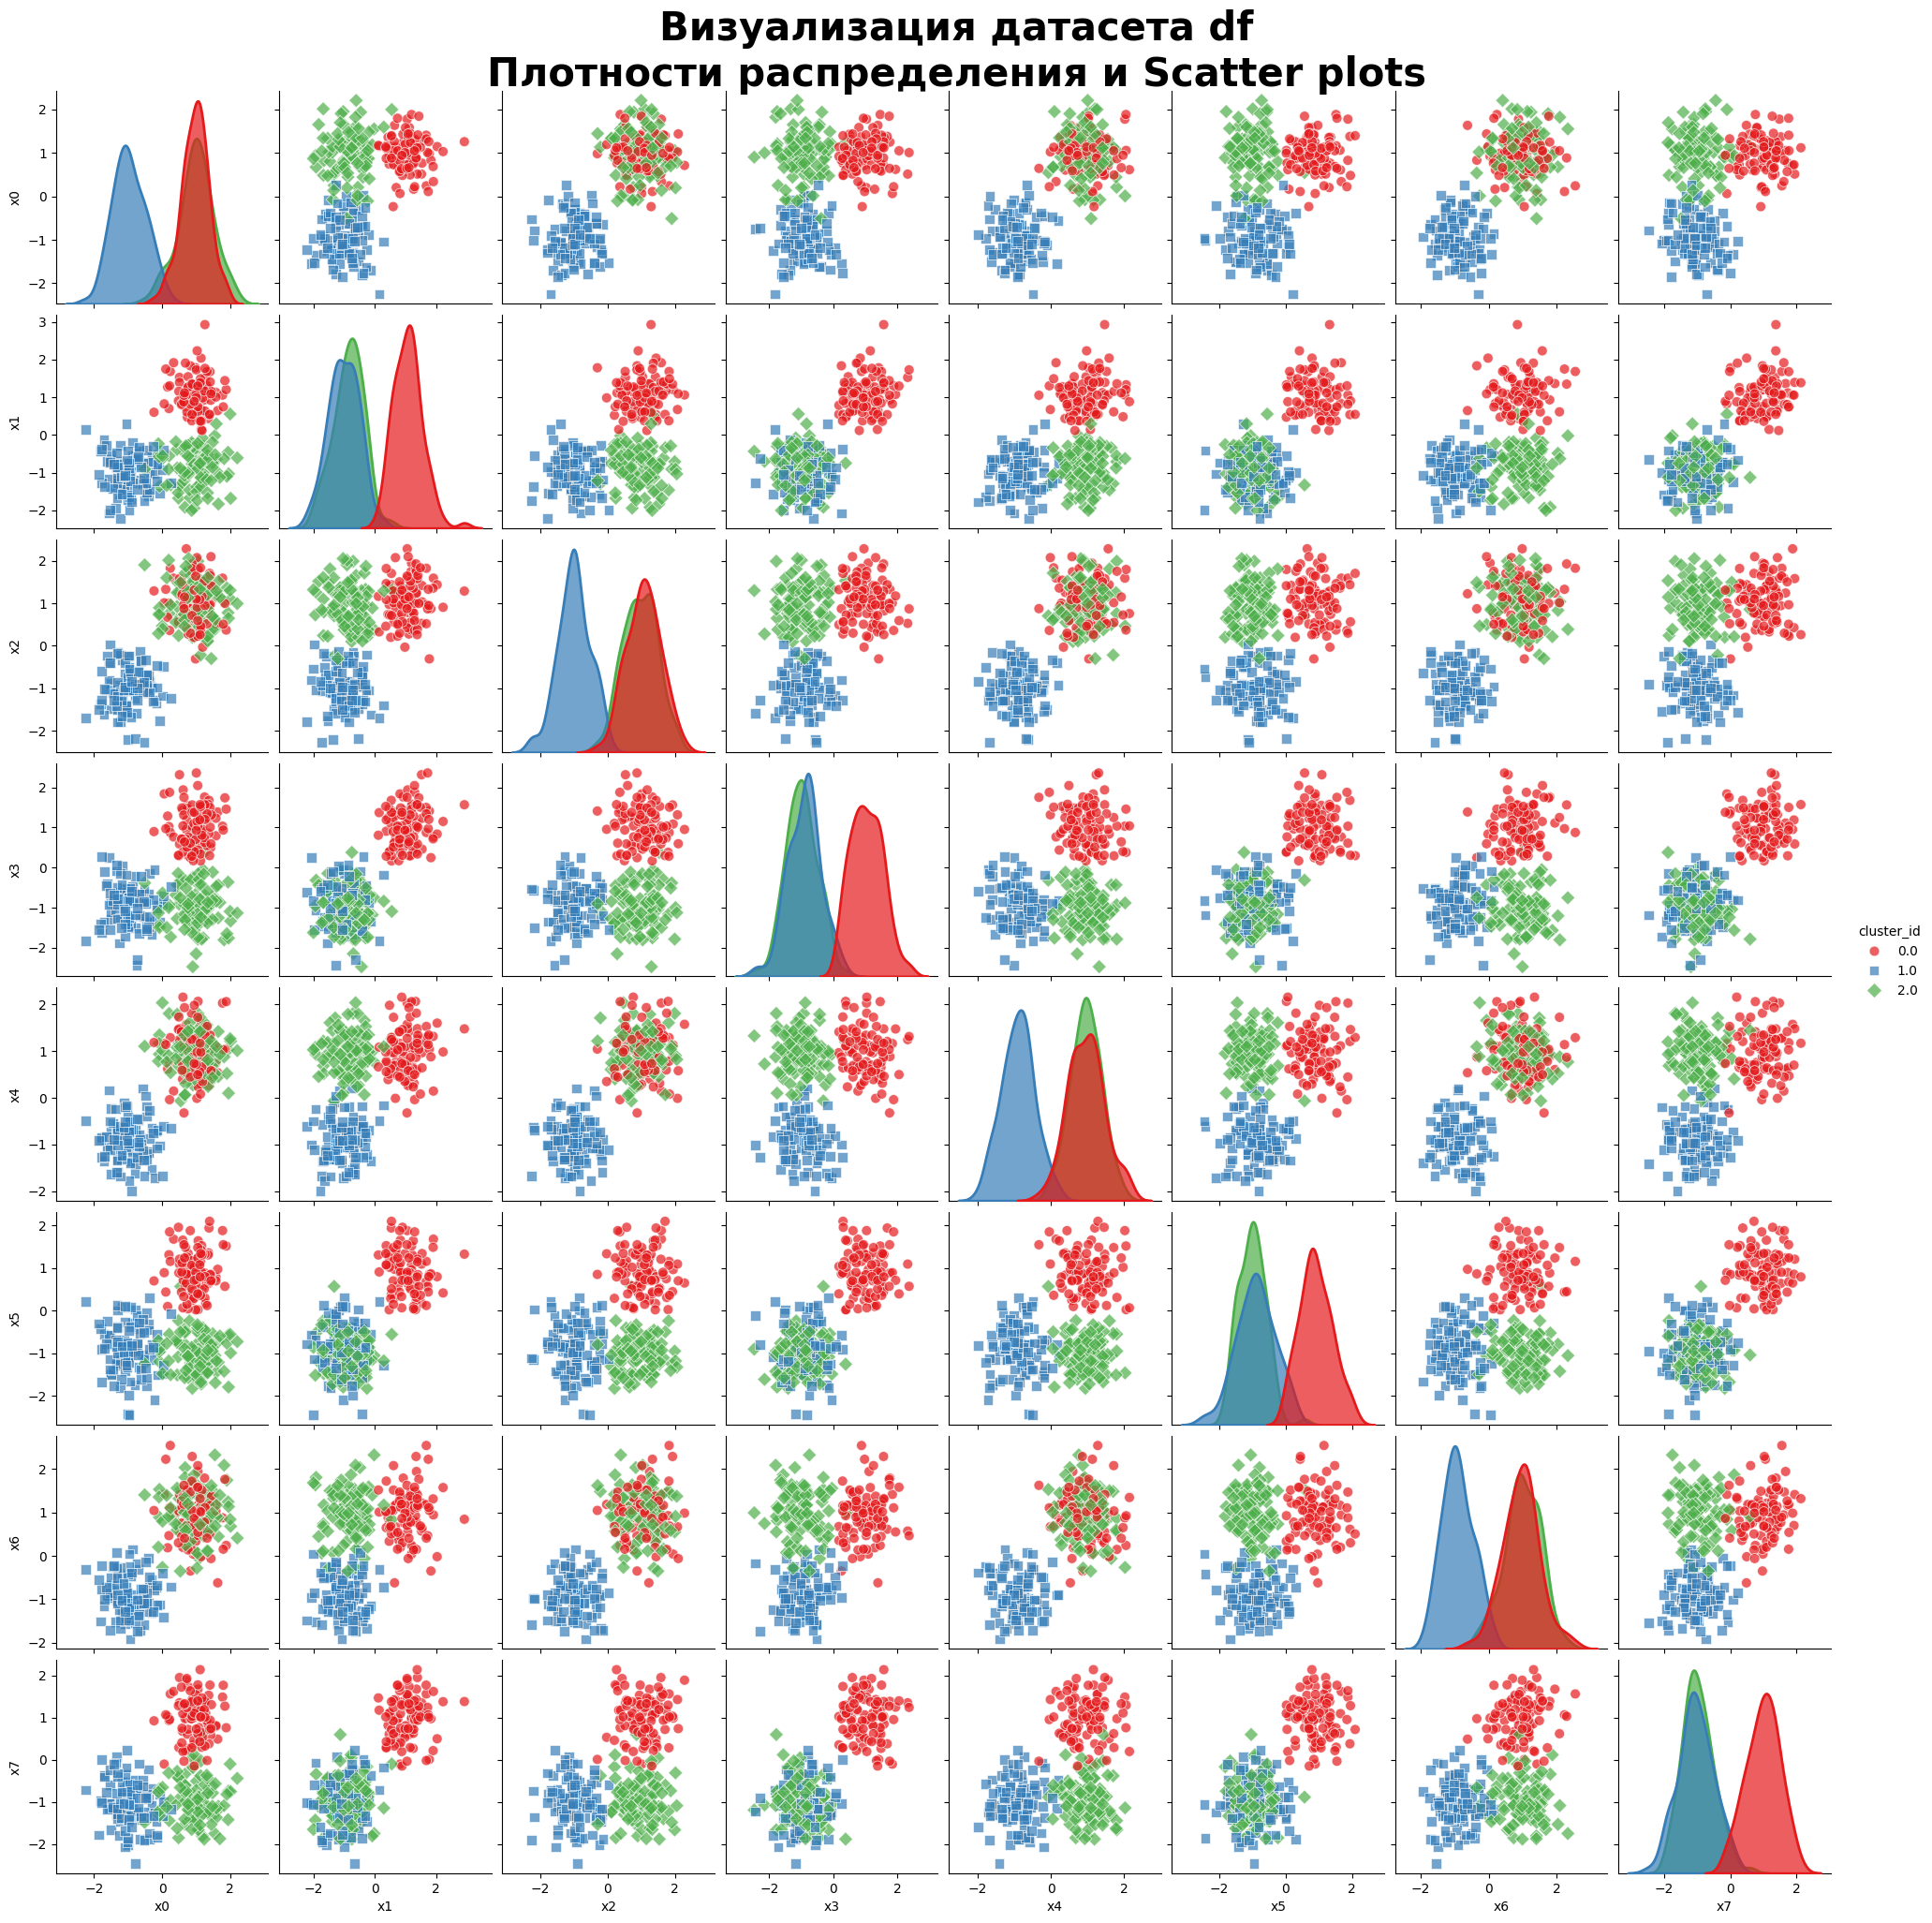

In [13]:
sns.pairplot(df,
             hue='cluster_id',
             palette='Set1',
             diag_kind='kde',
             diag_kws={'alpha': 0.7,
                      'linewidth': 2},
             markers=['o', 's', 'D'],   
             plot_kws={'alpha': 0.7,'s': 60})

plt.suptitle('Визуализация датасета df\n'
             'Плотности распределения и Scatter plots',
             fontsize=30,
             fontweight='bold',
             y=1.03) 

plt.show()

In [14]:
from scipy import stats

In [15]:
def correlation_with_pvalues(df, method='person'):
    """
    Calculates p-values using the t-distribution.
    For more information, see https://sky.pro/wiki/analytics/kak-poschitat-p-v-statistike-podrobnyj-gajd-dlya-nachinayushchih/
    
    The Pearson/Spearman correlation coefficient and p-value calculation are described in:
    Makarov, A. A., Tambovtseva, A. A., Vasilenok, N. A., "Correlation Coefficients." 
    Mathematics and Statistics, Part 2, Political Science Program, 2019-20 (May 28, 2020).
    https://allatambov.github.io/psms/pdf/associations.pdf
    
    Attentively :
        df - pd.DatFrame should contain only quantitative characteristics
    """
    
    corr_matrix = df.corr(method=method)
    numb_observations = len(df)
    
    p_values_mtrx = pd.DataFrame(np.zeros((df.shape[1],df.shape[1])), 
                            index = corr_matrix.index,
                            columns=corr_matrix.columns)
    
    for i in range(df.shape[1]):
        for j in range(df.shape[1]):
            if i==j:
                p_values_mtrx.iloc[i,j] = 0.0
            else:
                R = corr_matrix.iloc[i,j]
                if abs(R) == 1:
                    pvalue_matrix.iloc[i, j] = 0.0
                    
                if method=='spearman':
                    t = R * np.sqrt((numb_observations - 2)/(1 - R**2))
                    p_values_mtrx.iloc[i,j] = stats.t.sf(abs(t), df=numb_observations-2) * 2  
                else:
                    z = R*np.sqrt(numb_observations - 1)
                    p_values_mtrx.iloc[i,j] = stats.norm.sf(abs(z)) * 2 
    
    return corr_matrix, p_values_mtrx

In [16]:
corr_pearson_all, pvals_pearson_all = correlation_with_pvalues(df.drop('cluster_id', axis=1), 'pearson')

In [17]:
results_by_class = {}

class_idx = df['cluster_id'].unique()

for idx in class_idx:
    class_data = df[df['cluster_id'] == idx].drop('cluster_id', axis=1)
    corr_pearson, pvals_pearson = correlation_with_pvalues(class_data, 'pearson')
        
    results_by_class[idx] = {
        'pearson_corr': corr_pearson,
        'pearson_pvals': pvals_pearson,
    }

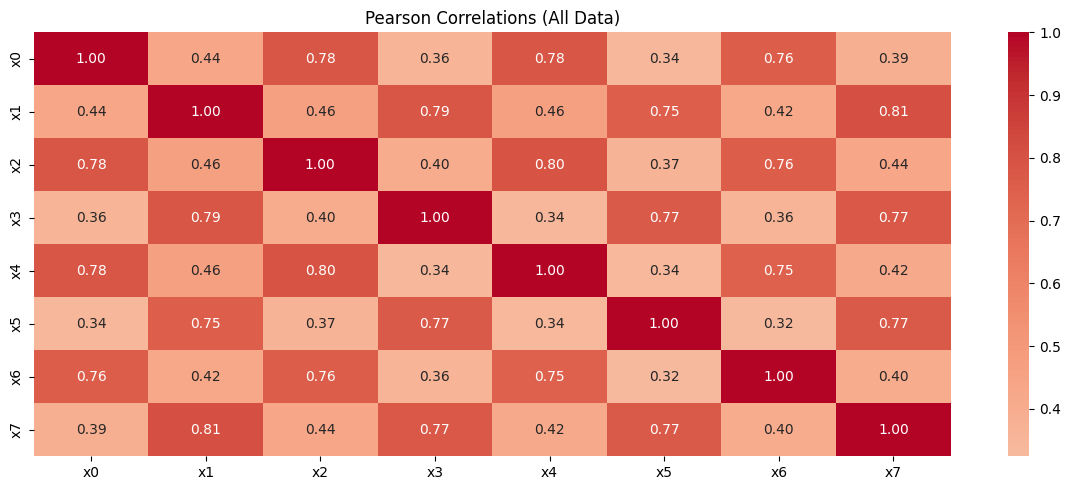

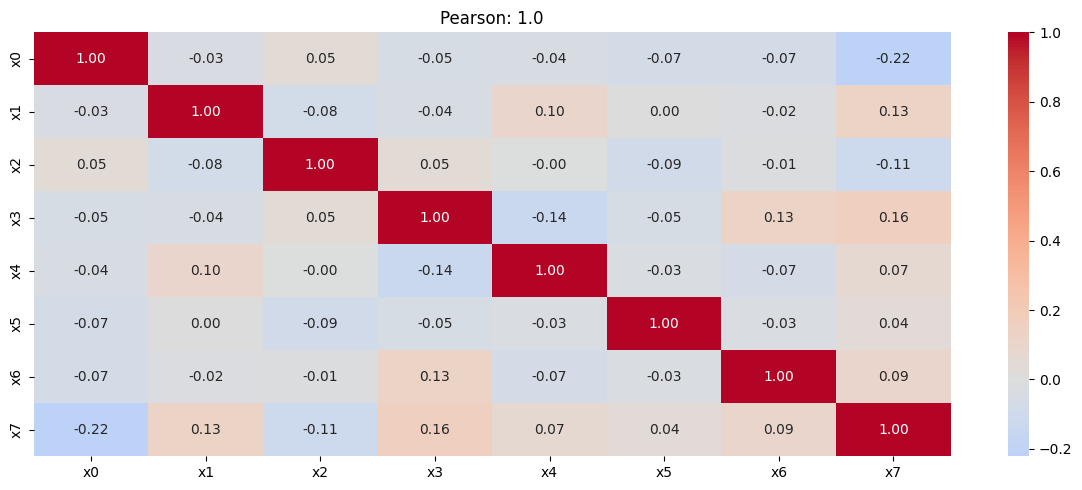

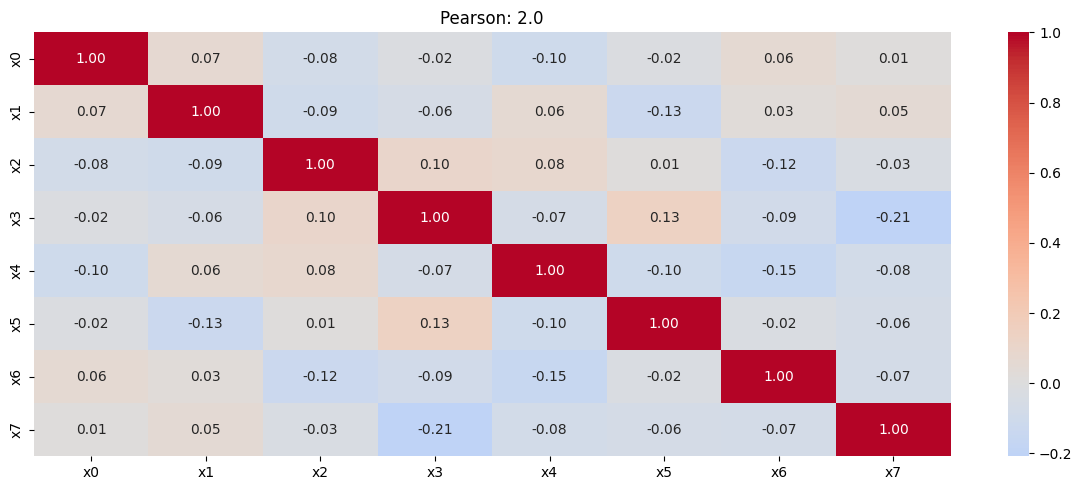

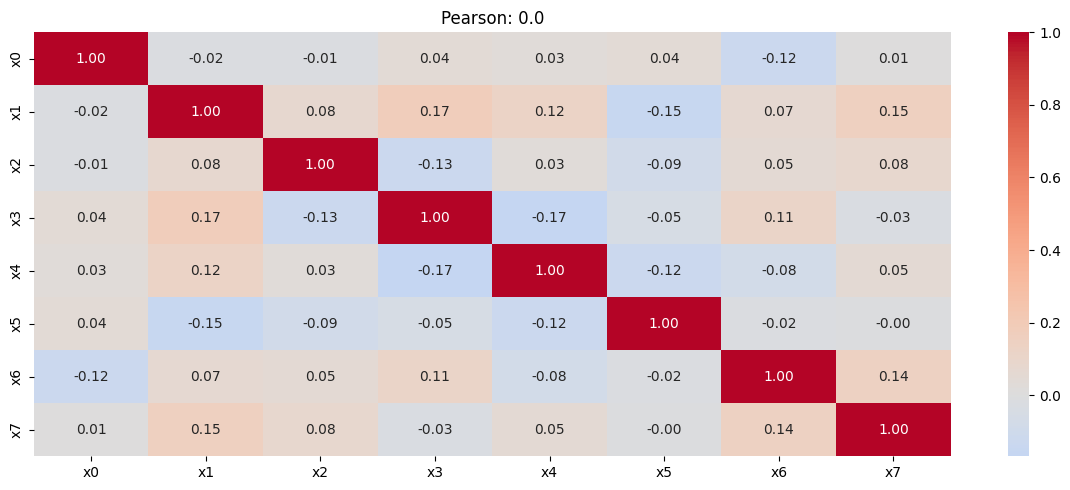

In [18]:
fig, ax = plt.subplots(figsize=(12, 5))

sns.heatmap(corr_pearson_all, annot=True, cmap='coolwarm', center=0, fmt='.2f')
ax.set_title('Pearson Correlations (All Data)')


plt.tight_layout()


for class_idx, results in results_by_class.items():
    fig, ax = plt.subplots(figsize=(12, 5))
    
    sns.heatmap(results['pearson_corr'], annot=True, cmap='coolwarm', center=0, fmt='.2f')
    ax.set_title(f'Pearson: {class_idx}')
    
    plt.tight_layout()
    
plt.show()

### task2

**Формулировка:** На основе созданного в пункте [1](#task1) датасета df сгенерировать отдельные
дополнительные датасеты (df_A_B), в которых к классу 0 добавлено A одинаковых точек
с координатами (-B,+B,-B,+B,-B,+B,-B,+B), где A = 1, 10, 100 и B = 1, 10, 100, при этом
количество объектов в остальных классах неизменно.

In [116]:
def task2(A : int, B : int, df : pd.DataFrame = df, class_id : int = 0) :
    point = [B if i%2==0 else -B for i in range(len(df.columns[:-1]))] + [class_id]
    points = [point] * A
    
    new_df = pd.DataFrame(points, columns=df.columns)
    return pd.concat([df, new_df], ignore_index=True)

In [117]:
A_values = [1, 10, 100]
B_values = [1, 10, 100]

A_B_dfs = {f"df_{A}_{B}": task2(A, B) for A in A_values for B in B_values}
all_dfs = {'df' : df, **A_B_dfs}

In [118]:
## какие-то проверки

assert (all_dfs['df_1_1'].iloc[-1].to_list() == list(map(float, [1,-1,1,-1,1,-1,1,-1, 0])))
assert (all_dfs['df_100_1'].iloc[-1].to_list() == list(map(float, [1,-1,1,-1,1,-1,1,-1, 0])))

assert (all_dfs['df_1_100'].iloc[-1].to_list() == list(map(float, [100,-100,100,-100,100,-100,100,-100, 0])))

new_stats = {}

new_stats["Number of object in each class"] = dict(all_dfs['df_100_100']['cluster_id'].value_counts())
new_stats['Dataset dimensionality'] = f"{all_dfs['df_100_100'].shape[0]} * {all_dfs['df_100_100'].shape[1]}"

new_stats

{'Number of object in each class': {0.0: np.int64(200),
  1.0: np.int64(100),
  2.0: np.int64(100)},
 'Dataset dimensionality': '400 * 9'}

### task3

**Формулировка:** 
1) Выбрать пару классов 0 и 1 и один количественный признак. Для каждого из датасетов из списка (df, df_A_B) в своем пространстве <br> Х-Y(количественный признак-класс) построить и визуализировать:
    - объекты, 
    - линию линейнойрегрессии,
    - линию логистической регрессии. 
    
*Регрессии строить на паре Х-Y(количественный признак-класс).*

2) Оценить качество работы полученных на основе логистической регрессии классификаторов, используя ROC кривые, восстановив на графике ROC-кривых определенную логистической регрессией точку классификации Sensitivity-Specificity и оценные бутстрепом доверительные интервалы CI95 (n=1000).

*Все полученные графики возможно расположить в две колонки: левая колонка –
визуализация пространства и регрессий, правая – графики с ROC кривой и точкой.*

***Матричная форма линейной регрессии была разобрана в [Лабораторной работе №1](https://github.com/ilushka-obnimashka/Statistical_decision_theory/blob/master/1lab.ipynb) (###task3-task5)+task10)***

In [119]:
class LinearRegression:
    def __init__(self) :
        self.weights = None
        self._feature_names = None
        self._classes = None
        self._class_to_int = None
        self._int_to_class = None
        
    def fit(self, df_or_X, y_or_target_col):
        if isinstance(df_or_X, pd.DataFrame):
            X = df_or_X.drop(columns=[y_or_target_col]).values
            y_series = df_or_X[y_or_target_col]
            self._feature_names = df_or_X.drop(columns=[y_or_target_col]).columns.tolist()
        else:
            X = df_or_X
            y_series = pd.Series(y_or_target_col)
            self._feature_names = [f'feature_{i}' for i in range(X.shape[1])]
        
        y = y_series.values
        n_samples, n_features = X.shape
        
        self._classes = np.unique(y_series)

        self._class_to_int = {cls: i for i, cls in enumerate(self._classes)}
        self._int_to_class = {i: cls for i, cls in enumerate(self._classes)}
        y = y_series.map(self._class_to_int).values.reshape(-1, 1)
        
        
        X_with_int = np.column_stack([np.ones(n_samples), X]) 
        
        try:
            beta = np.linalg.inv(X_with_int.T @ X_with_int) @ X_with_int.T @ y
            y_pred = X_with_int @ beta
            residuals = y - y_pred
        except (np.linalg.LinAlgError, ValueError):
            raise ValueError ("Ошибка: Невозможно вычислить коэффициенты регрессии.\
                              Матрица (X.T @ X) является вырожденной (сингулярной).")
        
        self.weights = beta
        return self
        
    
    def predict(self, X_or_df):
            if self.weights is None:
                raise RuntimeError("Модель не обучена")

            if isinstance(X_or_df, pd.DataFrame):
                try:
                    X = X_or_df[self._feature_names].values
                except KeyError:
                    raise ValueError("Колонки в X не соответствуют тем, на которых модель обучалась.")
            else:
                X = X_or_df

            n_samples, _ = X.shape
            X_with_int = np.column_stack([np.ones(n_samples), X])
            predictions = X_with_int @ self.weights
            return predictions.flatten()



#### *Справка*

##### Решение задачи Бинарной Классификации при помощи Логистической регрессии**


**Вычисление предсказания логистической регрессией для объекта $x_i \in \mathbb{R}^n$ :**

$z = w^T x_i + b, \quad w \in \mathbb{R}^n, b \in \mathbb{R}$
<br>
$a = \sigma (z)$,
<br>

**Формула Сигмоиды :**
$\sigma(x) = \frac{1}{1 + e^{-x}}$

<br>

<center>
  <img src="https://raw.githubusercontent.com/ilushka-obnimashka/Statistical_decision_theory/master/Images/The%20Linear-to-Logistic%20Transformation.png" width="500" alt="Переход из пространства линейной регрессии в пространство логистической регрессии">
  <br>
  Рис. 1: Переход из пространства линейной регрессии в пространство логистической регрессии.
</center>

**Логистическая фунция потерь:**

$$L_i(a) = -y_i \cdot log(a) - (1 - y_i) \cdot log(1 - a)$$

**Производные функции по параметрам:**

$$\frac{\partial L_i}{\partial w} = \frac{\partial L_i}{\partial a} \cdot \frac{\partial a}{\partial z} 
\cdot \frac{\partial z}{\partial w} = \frac {a - y_i} {a \cdot (1-a)} \cdot a \cdot (1-a) \cdot x_i = (a-y_i) \cdot x_i $$

$$\frac{\partial L_i}{\partial b} = \frac{\partial L_i}{\partial a} \cdot \frac{\partial a}{\partial z} 
\cdot \frac{\partial z}{\partial b} = \frac {a - y_i} {a \cdot (1-a)} \cdot a \cdot (1-a) \cdot 1 = a-y_i $$

*Используются для минимизации функции потерь $L$ с помощью градиентного спуска.*

In [120]:
import numpy as np
import pandas as pd

class BinaryLogisticRegression:
    
    def __init__(self):
        self.weights = None
        self.bias = None
        self._report_every = 40
        self.losses_train = []
        self._is_fit = False
        self._feature_names = None
        self._classes = None
        self._class_to_int = None
        self._int_to_class = None
        
    def _sigmoid(self, x):
        x_clipped = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x_clipped))
    
    def _log_loss(self, y_true, y_pred):
        return -np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred), axis=0) / len(y_true)
    
    def fit(self, df_or_X, y_or_target_col, learning_rate=0.005, epochs=40):
        
        if self._is_fit == True:
            print("Модель уже была обучена")
            return self
            
        if isinstance(df_or_X, pd.DataFrame):
            X = df_or_X.drop(columns=[y_or_target_col]).values
            if X.ndim == 1:
                X = X.reshape(-1, 1)
            y_series = df_or_X[y_or_target_col]
            self._feature_names = df_or_X.drop(columns=[y_or_target_col]).columns.tolist()
        else:
            X = df_or_X
            if X.ndim == 1:
                X = X.reshape(-1, 1)
            y_series = pd.Series(y_or_target_col)
            self._feature_names = [f'feature_{i}' for i in range(X.shape[1])]
            
        n_samples, n_features = X.shape
        
        self.weights = np.random.randn(n_features, 1) * 0.001
        self.bias = np.random.randn() * 0.001
        
        self._classes = np.unique(y_series)
        K = len(self._classes)
        
        if K != 2:
            raise ValueError(f"BinaryLogisticRegression поддерживает только 2 класса, получено {K}.")
            
        if n_samples <= K:
            raise ValueError("Число выборок (n_samples) должно быть больше числа классов (K).")

        self._class_to_int = {cls: i for i, cls in enumerate(self._classes)}
        self._int_to_class = {i: cls for i, cls in enumerate(self._classes)}
        y = y_series.map(self._class_to_int).values.reshape(-1, 1)
        
        for epoch in range(epochs):  
            
            Z = X @ self.weights + self.bias
            A = self._sigmoid(Z)
            
            dw = (1 / n_samples) * X.T.dot(A - y)
            db = (1 / n_samples) * np.sum(A - y)
            
            self.weights -= learning_rate * dw
            self.bias -= learning_rate * db
            
            if epoch % self._report_every == 0:
                self.losses_train.append(self._log_loss(y, A))
        
        self._is_fit = True
        return self
    
    
    def predict_proba(self, X_or_df):
        if not self._is_fit:
            raise RuntimeError("Модель не обучена. Вызовите .fit() перед предсказанием.")
            
        if isinstance(X_or_df, pd.DataFrame):
            try:
                X = X_or_df[self._feature_names].values
            except KeyError:
                raise ValueError("Колонки в X не соответствуют тем, на которых модель обучалась.")
        else:
            X = X_or_df
            
        if X.ndim == 1:
            X = X.reshape(-1, 1)
            
        Z = X.dot(self.weights) + self.bias
        A = self._sigmoid(Z)
        A_class_0 = 1 - A    
        
        return np.hstack([A_class_0, A])
        
    def predict(self, X_or_df, threshold=0.5):
        if not self._is_fit:
             raise RuntimeError("Модель не обучена. Вызовите .fit() перед предсказанием.")
        
        probas = self.predict_proba(X_or_df)
        binary_preds = (probas >= threshold).astype(int)
        
        return np.array([self._int_to_class[pred] for pred in binary_preds])

In [121]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.utils import resample

In [122]:
def run_roc_bootstrap(model_class, X_boot, y_boot, pos_label):
    """
    Вспомогательная функция для одного шага бутстрэпа.
    Принимает КЛАСС модели, а не экземпляр.
    """
    if len(np.unique(y_boot)) < 2:
        return None, None
    
    try:
        model_boot = model_class().fit(X_boot, y_boot)
        
        y_scores_boot = model_boot.predict_proba(X_boot)[:, pos_label]
        
        fpr_boot, tpr_boot, _ = roc_curve(y_boot, y_scores_boot, pos_label=pos_label)
        auc_boot = auc(fpr_boot, tpr_boot)
        
        base_fpr = np.linspace(0, 1, 101)
        tpr_interp = np.interp(base_fpr, fpr_boot, tpr_boot)
        tpr_interp[0] = 0.0
        
        return tpr_interp, auc_boot
        
    except Exception as e:
        print(f"Ошибка бутстрэпа: {e}")
        return None, None

In [123]:
def plot_roc_with_point_and_ci(ax, model_instance, model_class, X_train, y_train, n_bootstraps, pos_label):
    
    y_scores_main = model_instance.predict_proba(X_train)[:, pos_label] 
    
    fpr_main, tpr_main, thresholds_main = roc_curve(y_train, y_scores_main, pos_label=pos_label)
    auc_main = auc(fpr_main, tpr_main)
    
    ax.plot(fpr_main, tpr_main, color='b', label=f'AUROC = {auc_main:0.4f}', lw=2)
    
    y_pred_binary_0_5 = (y_scores_main >= 0.5).astype(int)
    
    try:
        tn, fp, fn, tp = confusion_matrix(y_train, y_pred_binary_0_5, labels=[0, 1]).ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        fpr_point = 1 - specificity
        tpr_point = sensitivity     
        ax.plot(fpr_point, tpr_point, 'ro', markersize=10, 
                label=f'Порог 0.5\nSens={tpr_point:0.2f}\nSpec={specificity:0.2f}')
    except ValueError:
        print("Не удалось рассчитать точку (Sens, Spec).")


    print(f"Запуск {n_bootstraps} итераций бутстрэпа...")
    tprs_boot, aucs_boot = [], []
    base_fpr = np.linspace(0, 1, 101)

    for i in range(n_bootstraps):
        X_boot, y_boot = resample(X_train, y_train, n_samples=len(y_train), replace=True, random_state=i)
        
        tpr_interp, auc_val = run_roc_bootstrap(model_class, X_boot, y_boot, pos_label)
        
        if tpr_interp is not None:
            tprs_boot.append(tpr_interp)
            aucs_boot.append(auc_val)
            
    print("...Бутстрэп завершен.")

    if tprs_boot:
        tprs_arr = np.array(tprs_boot)
        tpr_lower = np.percentile(tprs_arr, 2.5, axis=0)
        tpr_upper = np.percentile(tprs_arr, 97.5, axis=0)
        ci_lower, ci_upper = np.percentile(aucs_boot, 2.5), np.percentile(aucs_boot, 97.5)
        ci_text = f"AUROC 95% CI: [{ci_lower:0.4f} - {ci_upper:0.4f}]"
        
        ax.fill_between(base_fpr, tpr_lower, tpr_upper, color='grey', alpha=0.3, label=f'95% Conf. Band')
        ax.text(0.5, 0.2, ci_text, ha='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
    
    ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Случайность')
    ax.set_xlabel('False Positive Rate (1 - Specificity)')
    ax.set_ylabel('True Positive Rate (Sensitivity)')
    ax.set_title('ROC-анализ (с CI 95% и точкой)')
    ax.legend(loc='lower right', fontsize=9)
    ax.set_aspect('equal')
    
    return {'AUROC': auc_main, 'CI_95': (ci_lower, ci_upper) if tprs_boot else None}

In [124]:
def task3(all_datasets, classes_to_analyze, feature_to_use, n_bootstraps, positive_class):

    if positive_class not in classes_to_analyze:
        raise ValueError(f"Позитивный класс {positive_class} не найден в {classes_to_analyze}")
        
    c_pos = positive_class
    c_neg = classes_to_analyze[0] if classes_to_analyze[1] == c_pos else classes_to_analyze[1]
    
    class_map = {c_neg: 0, c_pos: 1}
    print(f"Маппинг классов: {class_map} (Позитивный = {c_pos})")
    for df_name, df_data in all_datasets.items():
        
        print(f"\n{'='*30}\n АНАЛИЗ: {df_name}\n{'='*30}")

        df_subset = df_data[df_data['cluster_id'].isin(classes_to_analyze)].copy()
        
        df_subset['cluster_binary'] = df_subset['cluster_id'].map(class_map)
        
        X_1d = df_subset[[feature_to_use]].values 
        y_binary = df_subset['cluster_binary'].values 
        
        print(f"Размер данных (Классы {classes_to_analyze}): {X_1d.shape}")
        
        lin_reg = LinearRegression()
        lin_reg.fit(X_1d, y_binary)
        
        log_reg = BinaryLogisticRegression()
        log_reg.fit(X_1d, y_binary, learning_rate=0.01, epochs=1000)
        
        fig, axes = plt.subplots(1, 2, figsize=(18, 8))
        fig.suptitle(f"Анализ: {df_name} (Признак: {feature_to_use})", 
                     fontsize=16, weight='bold')
        
        ax_reg = axes[0]
        
        plot_mask = (X_1d.flatten() > -5)
        X_1d_plot = X_1d[plot_mask]
        y_binary_plot = y_binary[plot_mask]
        
        jitter = 0.05
        y_jittered_plot = y_binary_plot + np.random.uniform(-jitter, jitter, size=y_binary_plot.shape)
        
        mask_neg = (y_binary_plot == 0) 
        mask_pos = (y_binary_plot == 1) 
        
        ax_reg.scatter(X_1d_plot[mask_neg], y_jittered_plot[mask_neg], 
                       alpha=0.5, c='blue', 
                       label=f'Класс {c_neg} (Негативный)')
        
        ax_reg.scatter(X_1d_plot[mask_pos], y_jittered_plot[mask_pos], 
                       alpha=0.5, c='red', 
                       label=f'Класс {c_pos} (Позитивный, y=1)')

        x_line = np.linspace(X_1d.min(), X_1d.max(), 200).reshape(-1, 1)
        
        y_lin = lin_reg.predict(x_line)
        ax_reg.plot(x_line, y_lin, 'g-', lw=2, label='Линейная регрессия')
        
        y_log_proba = log_reg.predict_proba(x_line)[:, 1] 
        ax_reg.plot(x_line, y_log_proba, 'r-', lw=2, label='Логистическая регрессия (P(y=1))')
        
        ax_reg.set_xlim(-5, 5) 
        
        ax_reg.set_title('Пространство (Признак, Класс) и Регрессии')
        ax_reg.set_xlabel(feature_to_use)
        ax_reg.set_ylabel('Класс (0 или 1)')
        
        ax_reg.legend(); ax_reg.grid(True, linestyle='--', alpha=0.6)
        
        ax_roc = axes[1]
        
        plot_roc_with_point_and_ci(
            ax=ax_roc,
            model_instance=log_reg,            
            model_class=BinaryLogisticRegression, 
            X_train=X_1d,
            y_train=y_binary,
            n_bootstraps=n_bootstraps,
            pos_label=1 
        )
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.94])
        plt.show()

Маппинг классов: {1: 0, 0: 1} (Позитивный = 0)

 АНАЛИЗ: df
Размер данных (Классы [0, 1]): (200, 1)
Запуск 1000 итераций бутстрэпа...
...Бутстрэп завершен.


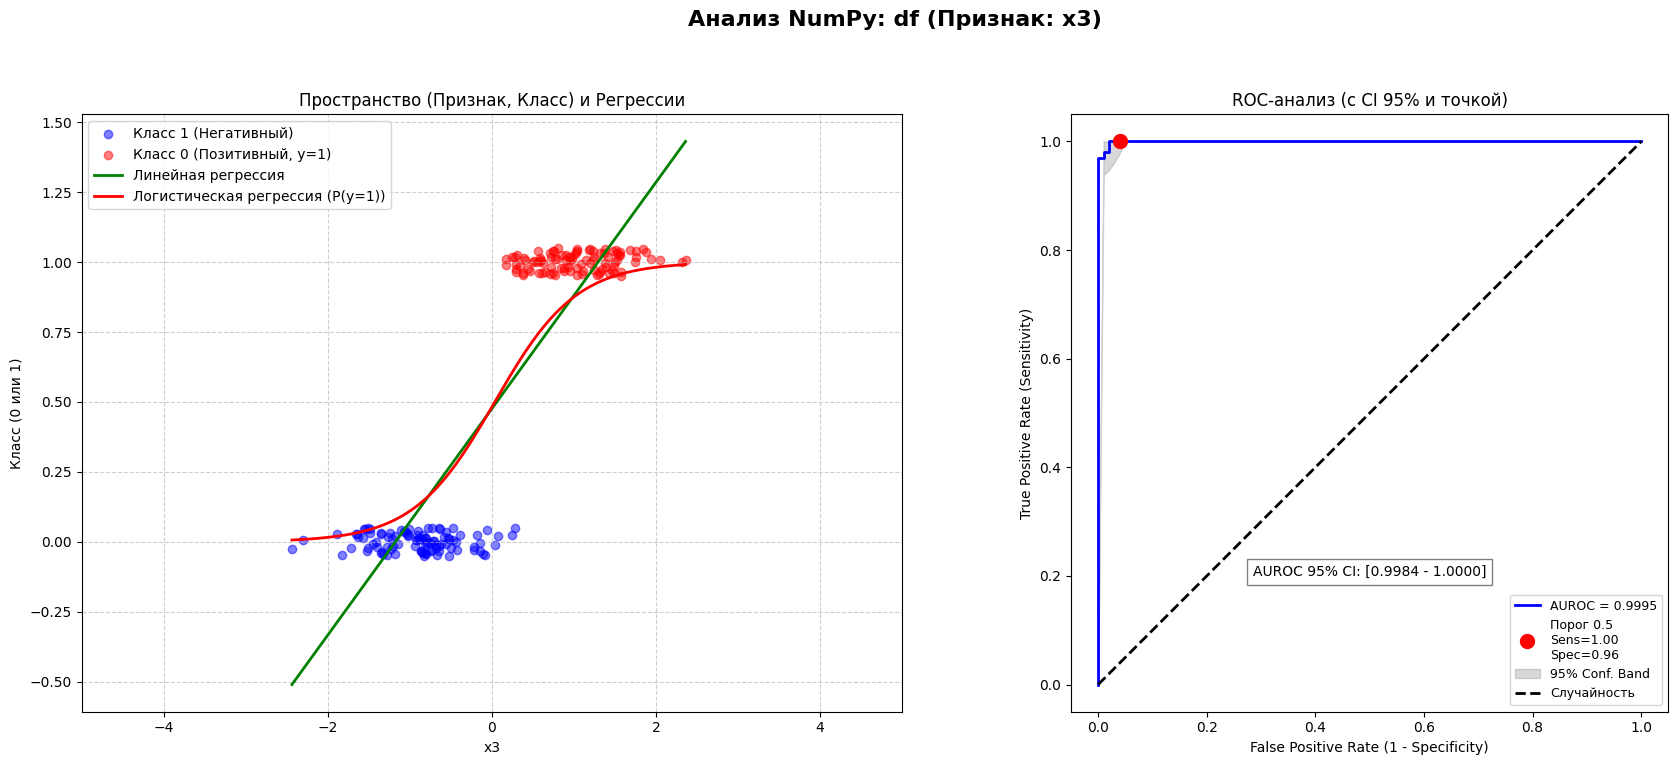


 АНАЛИЗ: df_1_1
Размер данных (Классы [0, 1]): (201, 1)
Запуск 1000 итераций бутстрэпа...
...Бутстрэп завершен.


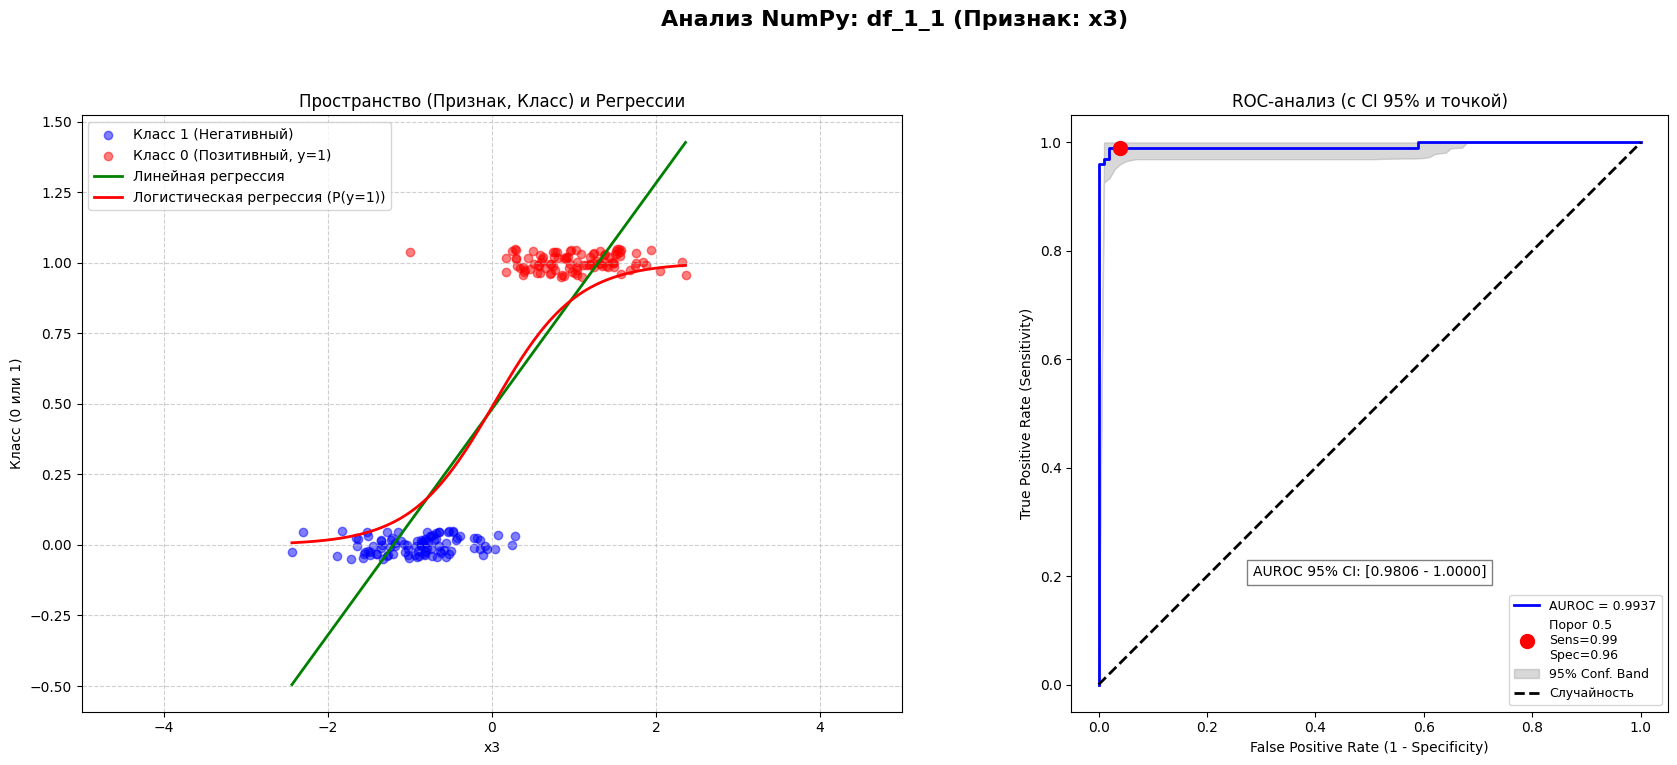


 АНАЛИЗ: df_1_10
Размер данных (Классы [0, 1]): (201, 1)
Запуск 1000 итераций бутстрэпа...
...Бутстрэп завершен.


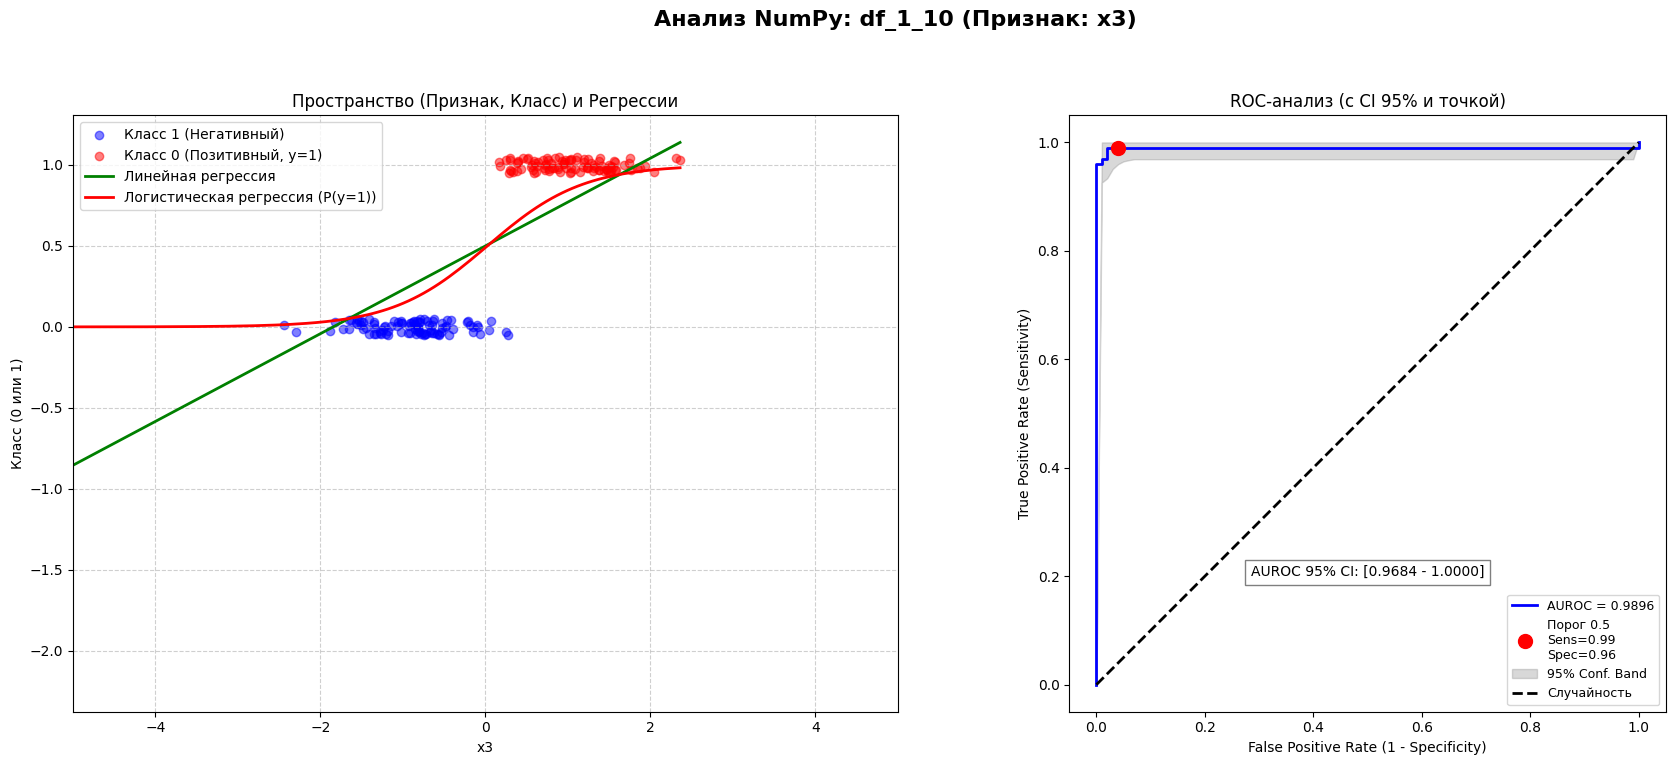


 АНАЛИЗ: df_1_100
Размер данных (Классы [0, 1]): (201, 1)
Запуск 1000 итераций бутстрэпа...
...Бутстрэп завершен.


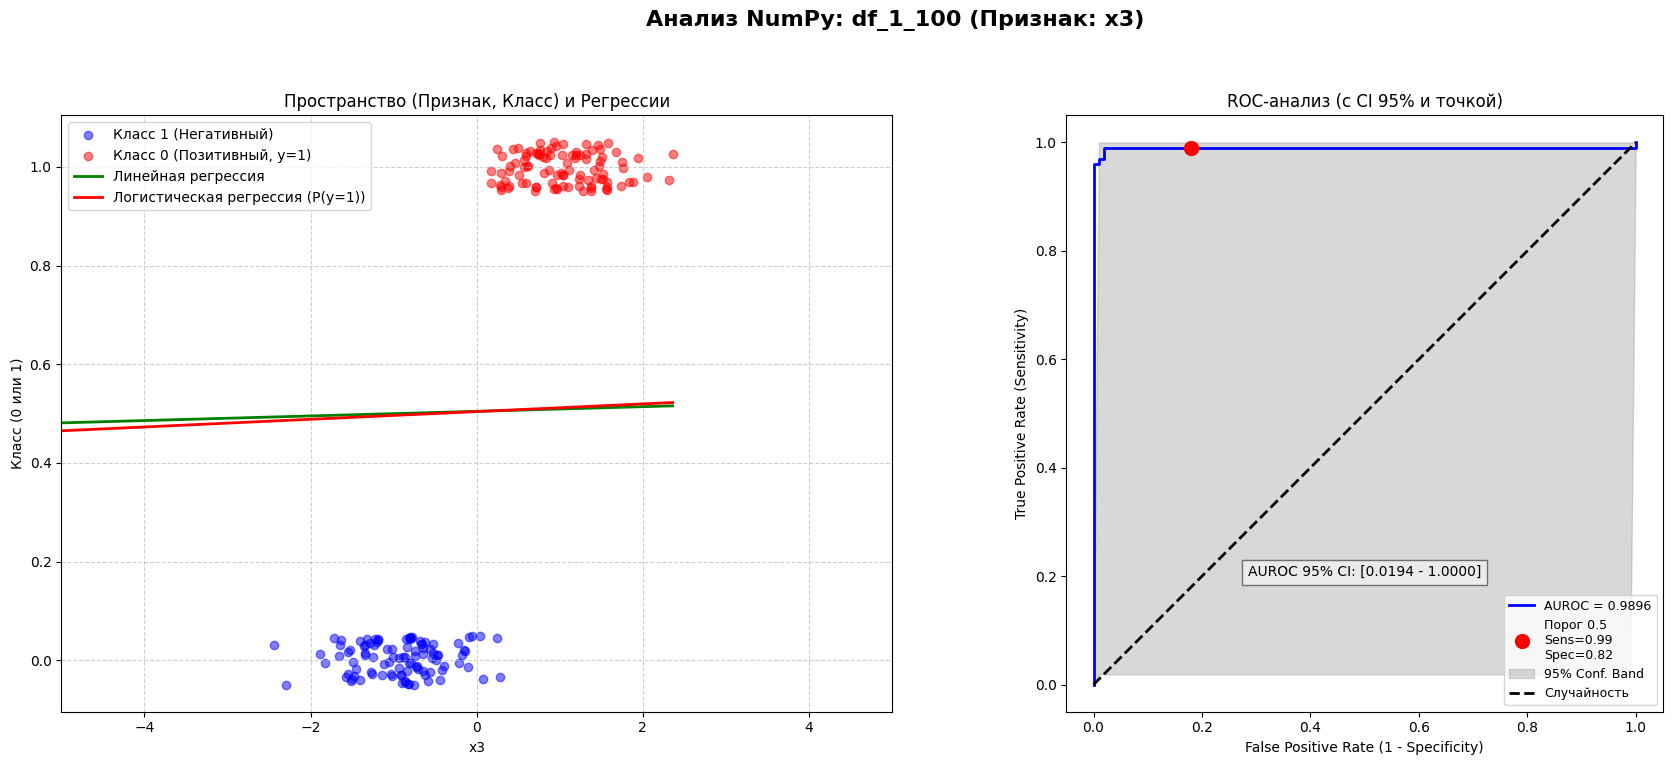


 АНАЛИЗ: df_10_1
Размер данных (Классы [0, 1]): (210, 1)
Запуск 1000 итераций бутстрэпа...
...Бутстрэп завершен.


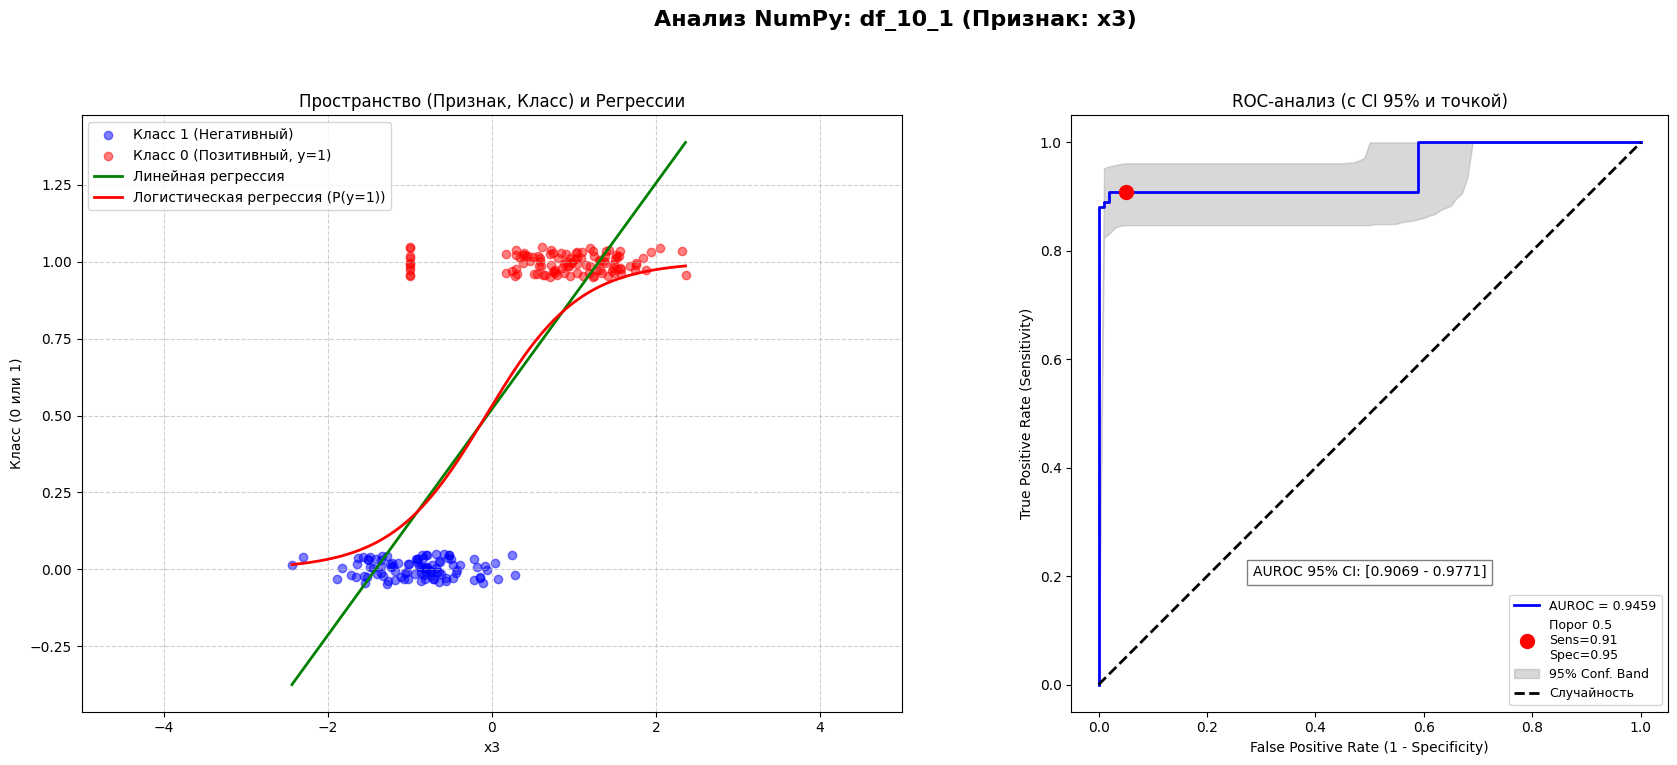


 АНАЛИЗ: df_10_10
Размер данных (Классы [0, 1]): (210, 1)
Запуск 1000 итераций бутстрэпа...
...Бутстрэп завершен.


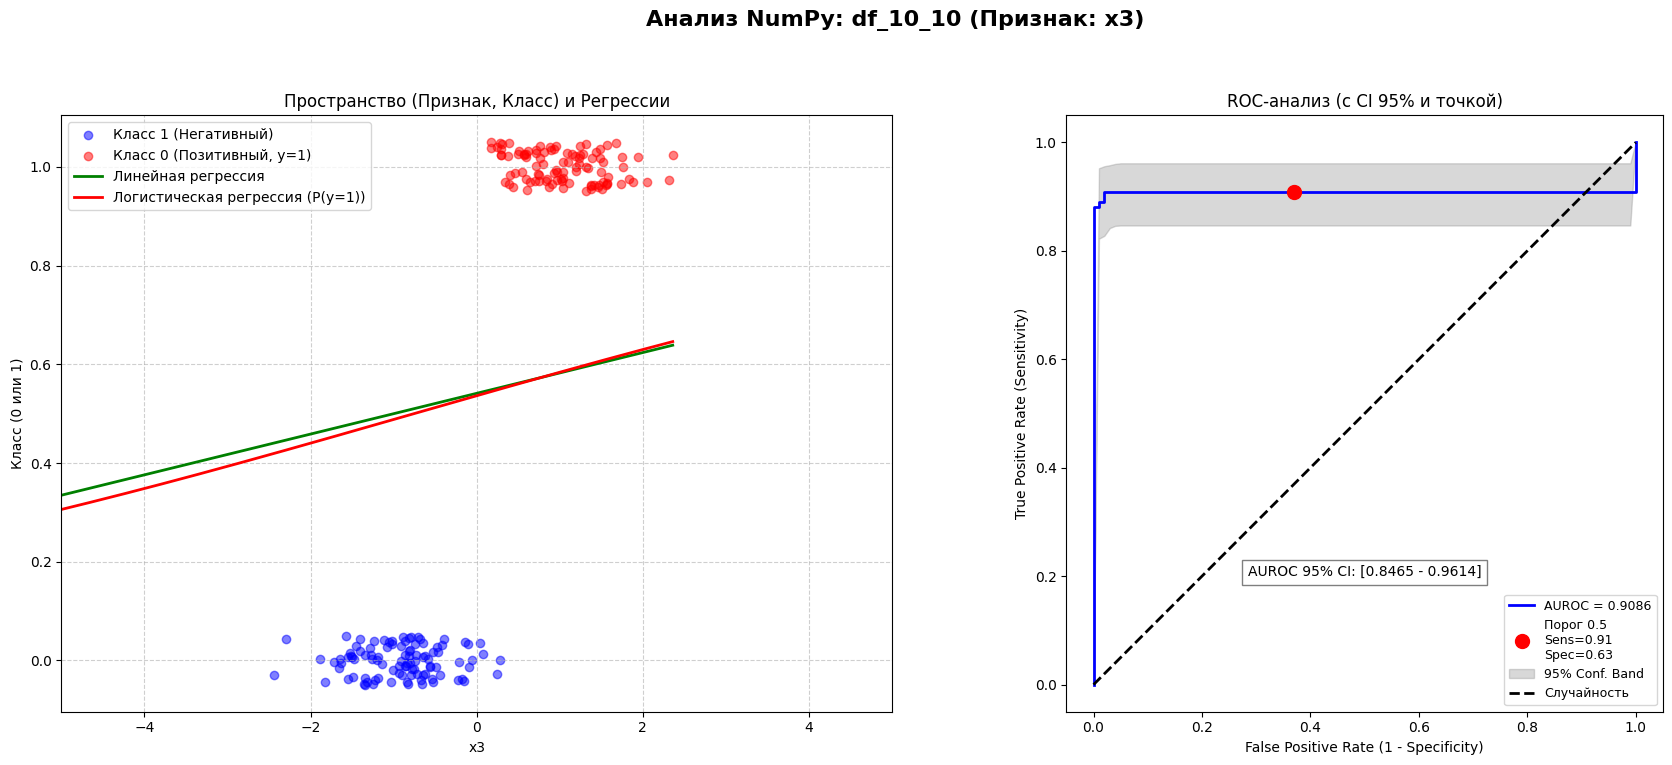


 АНАЛИЗ: df_10_100
Размер данных (Классы [0, 1]): (210, 1)
Запуск 1000 итераций бутстрэпа...
...Бутстрэп завершен.


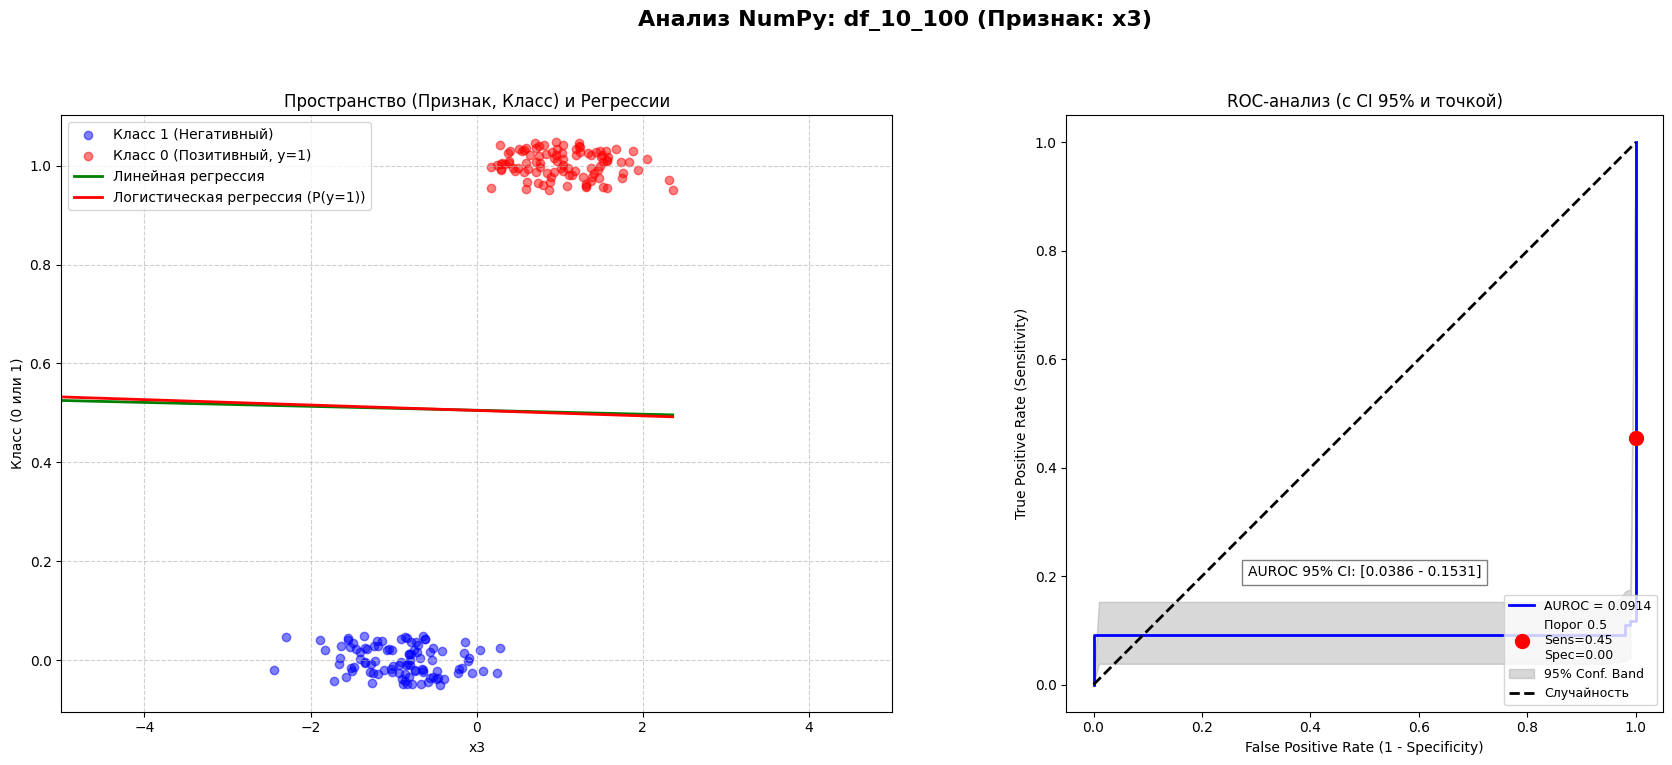


 АНАЛИЗ: df_100_1
Размер данных (Классы [0, 1]): (300, 1)
Запуск 1000 итераций бутстрэпа...
...Бутстрэп завершен.


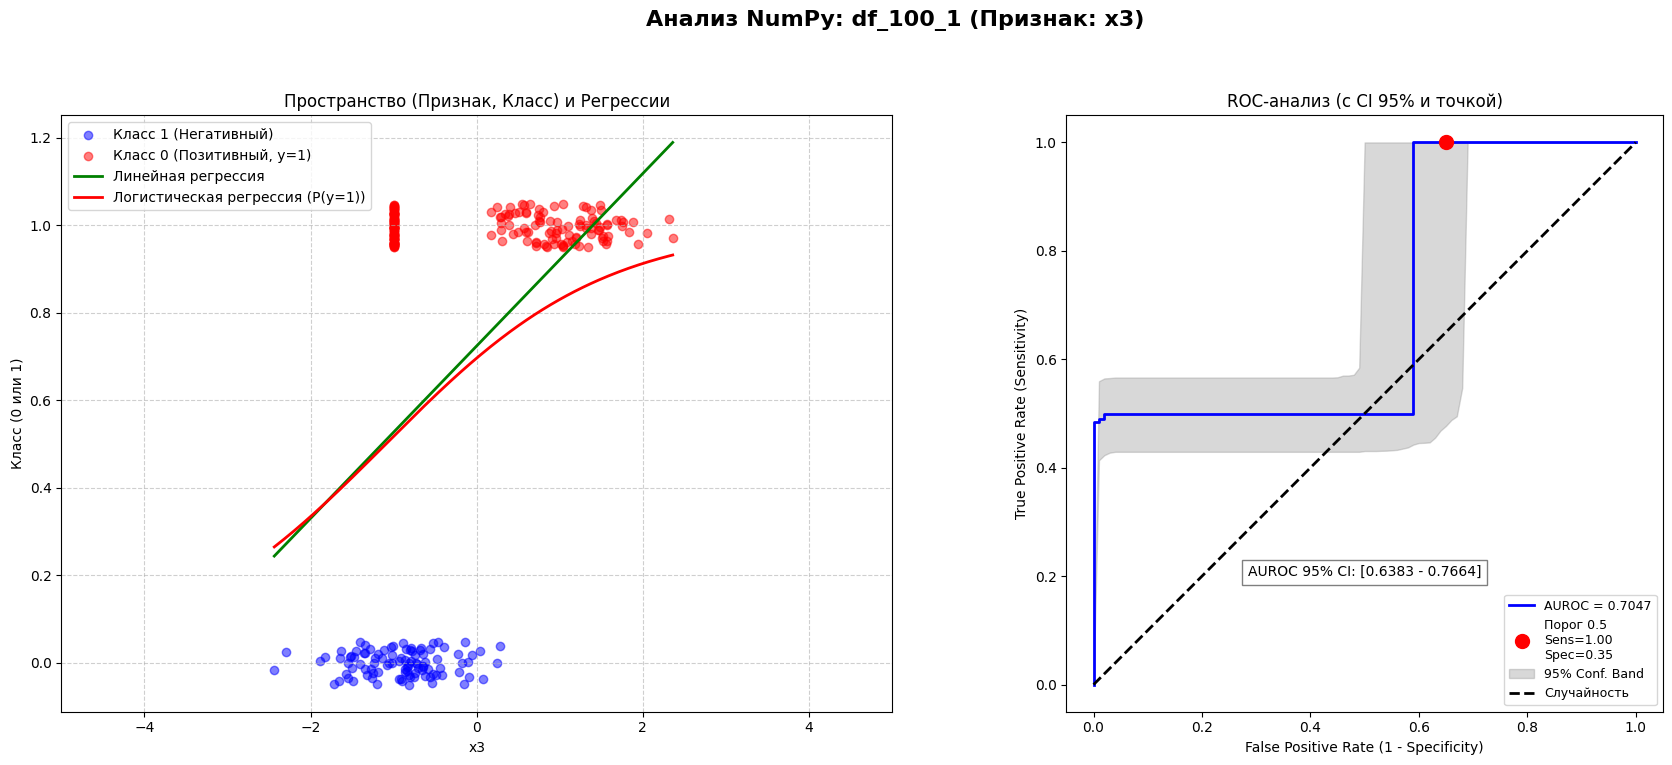


 АНАЛИЗ: df_100_10
Размер данных (Классы [0, 1]): (300, 1)
Запуск 1000 итераций бутстрэпа...
...Бутстрэп завершен.


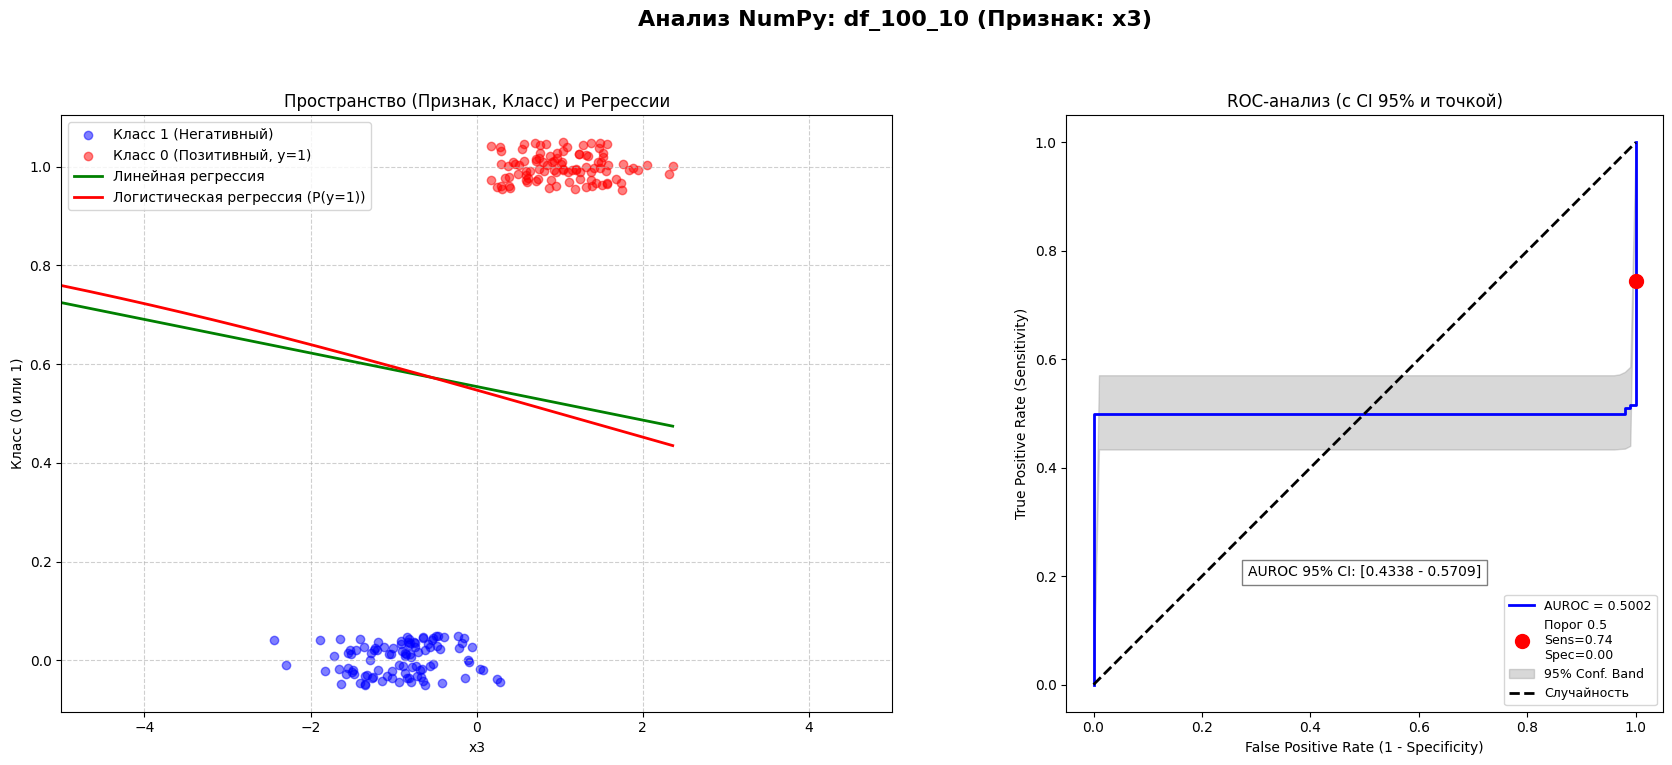


 АНАЛИЗ: df_100_100
Размер данных (Классы [0, 1]): (300, 1)
Запуск 1000 итераций бутстрэпа...
...Бутстрэп завершен.


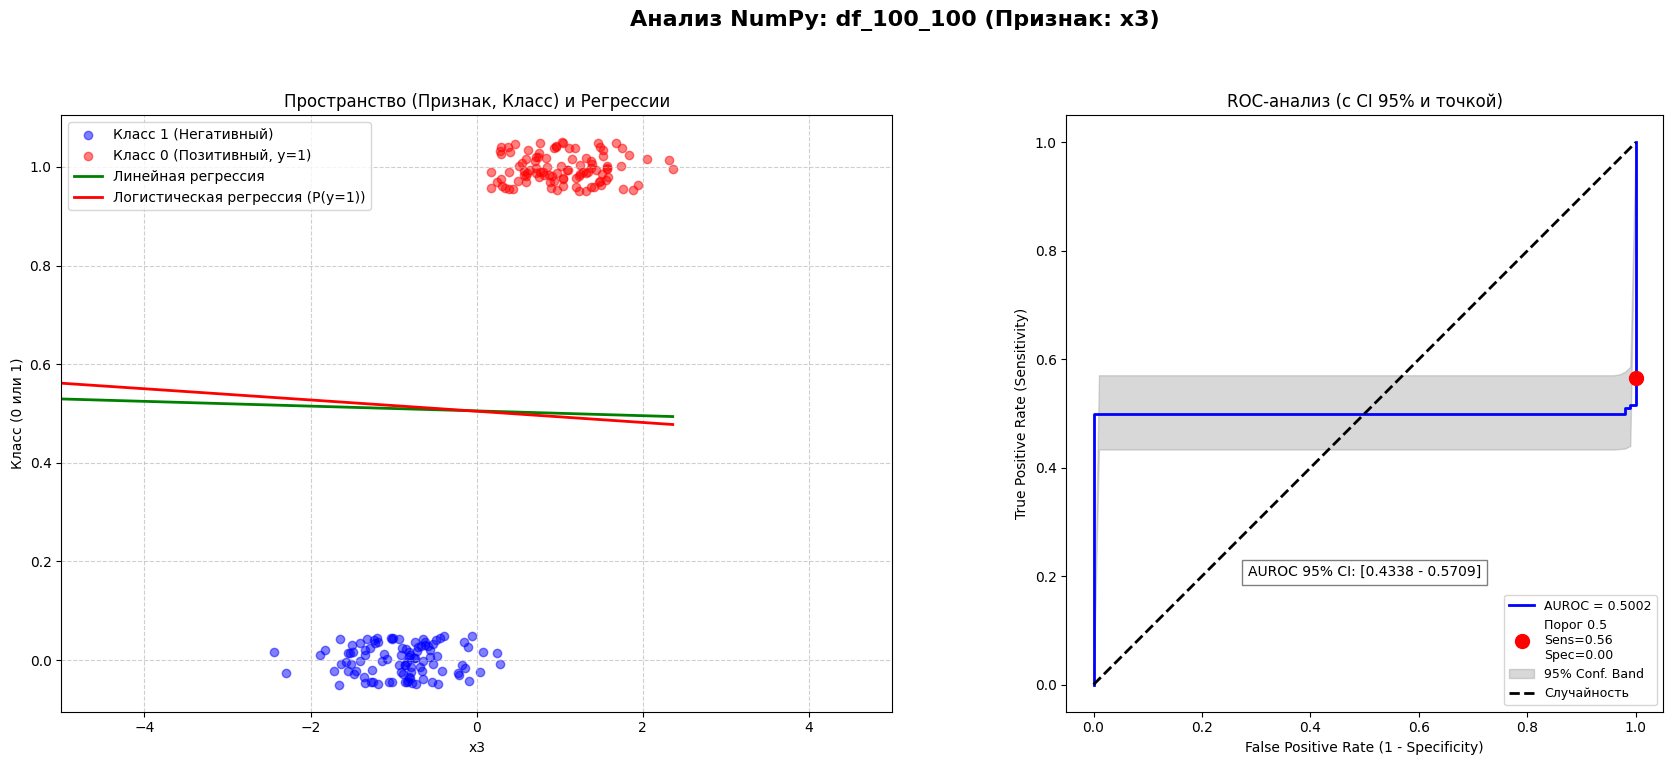

In [125]:
FEATURE_TO_USE = "x3"
CLASSES_TO_ANALYZE = [0, 1]
N_BOOTSTRAPS = 1000

task3(
    all_dfs, 
    CLASSES_TO_ANALYZE, 
    feature_to_use=FEATURE_TO_USE, 
    n_bootstraps=1000, 
    positive_class=0  
)

Маппинг классов: {0: 0, 1: 1} (Позитивный = 1)

 АНАЛИЗ: df
Размер данных (Классы [0, 1]): (200, 1)
Запуск 1000 итераций бутстрэпа...
...Бутстрэп завершен.


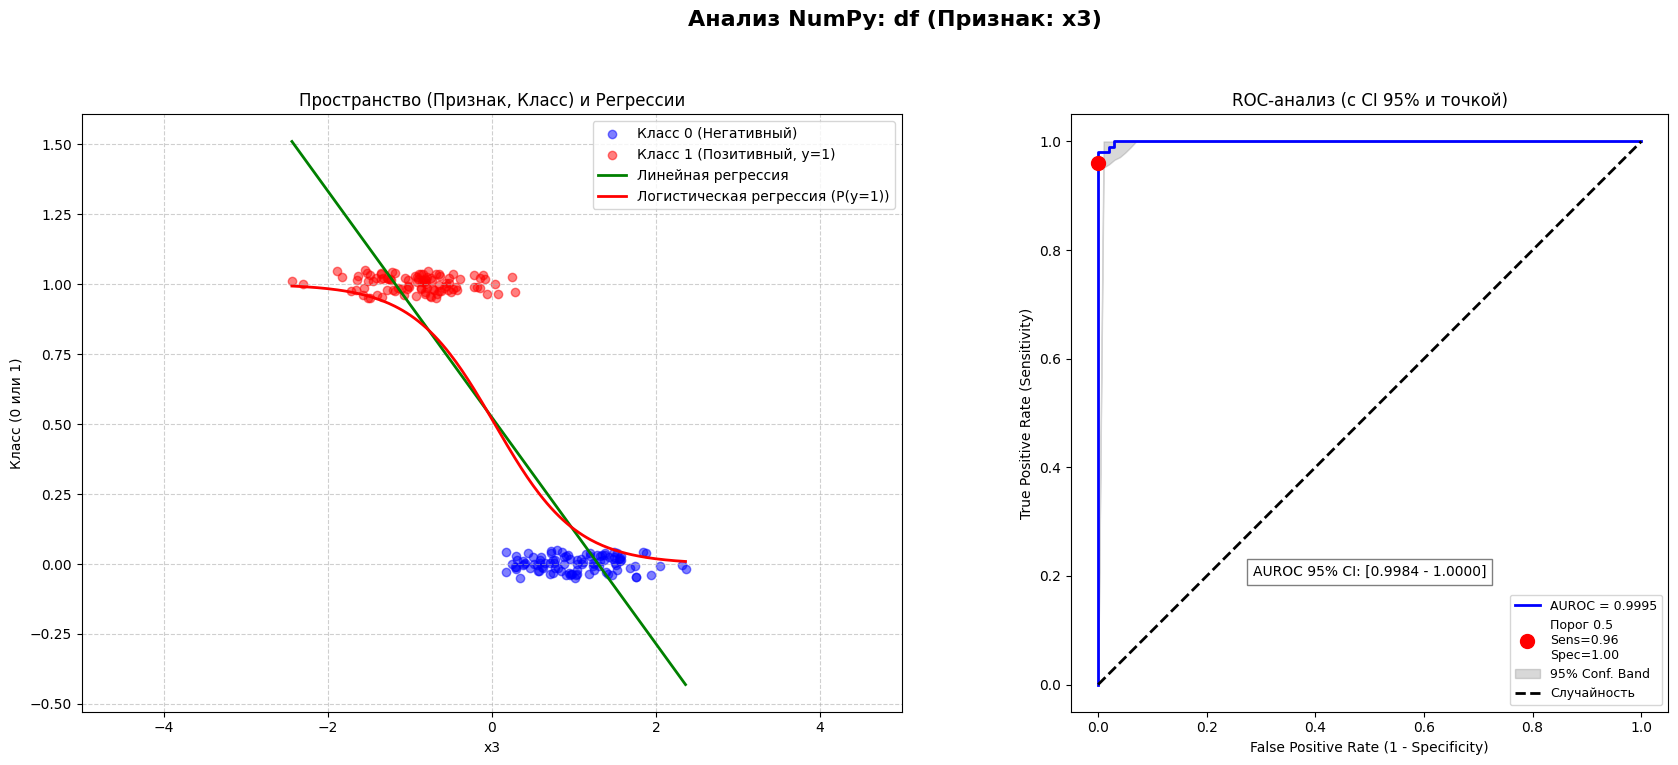


 АНАЛИЗ: df_1_1
Размер данных (Классы [0, 1]): (201, 1)
Запуск 1000 итераций бутстрэпа...
...Бутстрэп завершен.


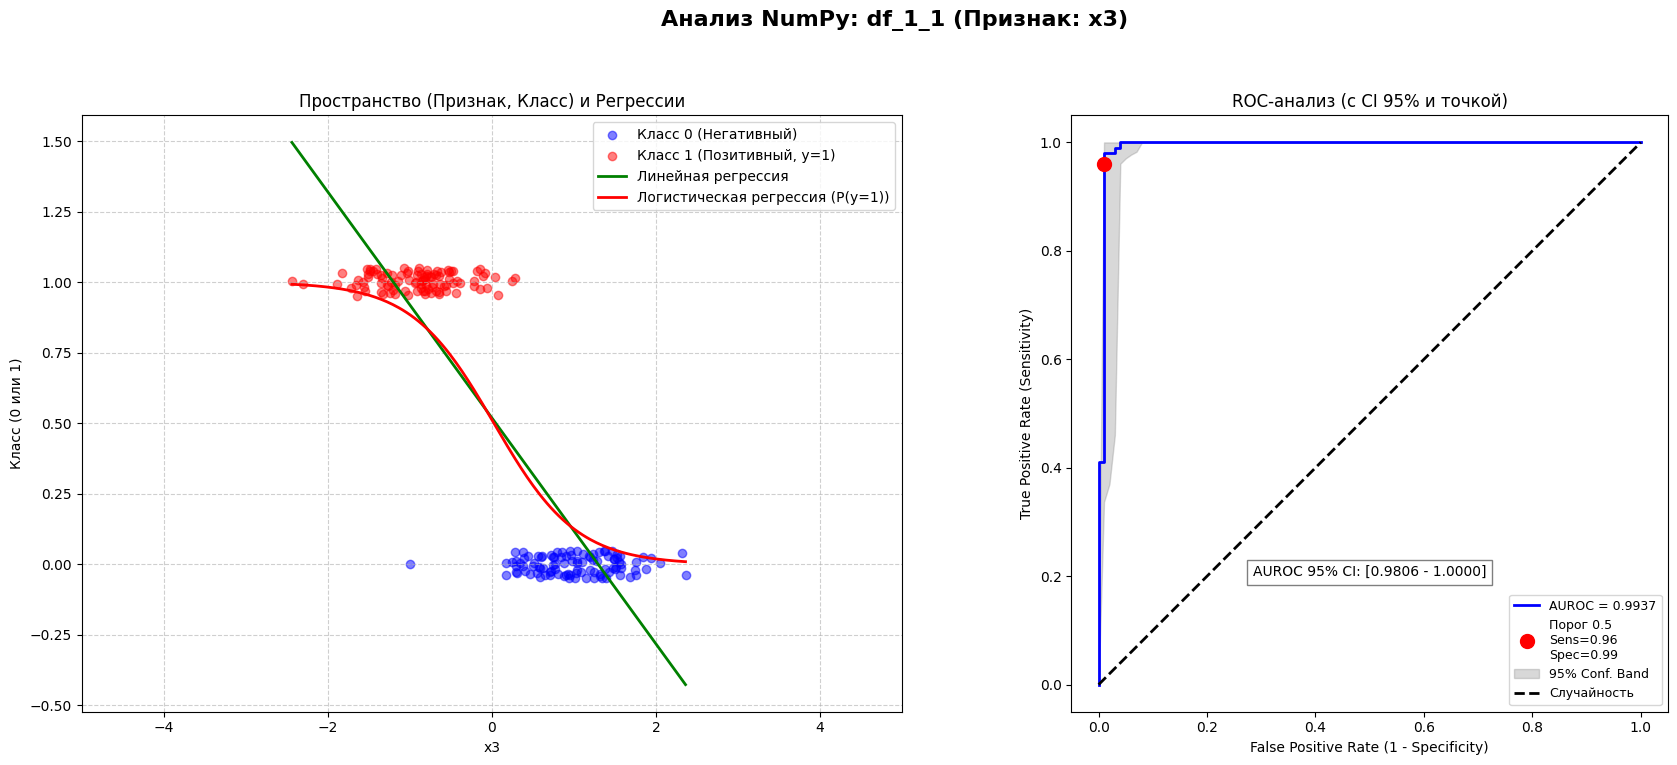


 АНАЛИЗ: df_1_10
Размер данных (Классы [0, 1]): (201, 1)
Запуск 1000 итераций бутстрэпа...
...Бутстрэп завершен.


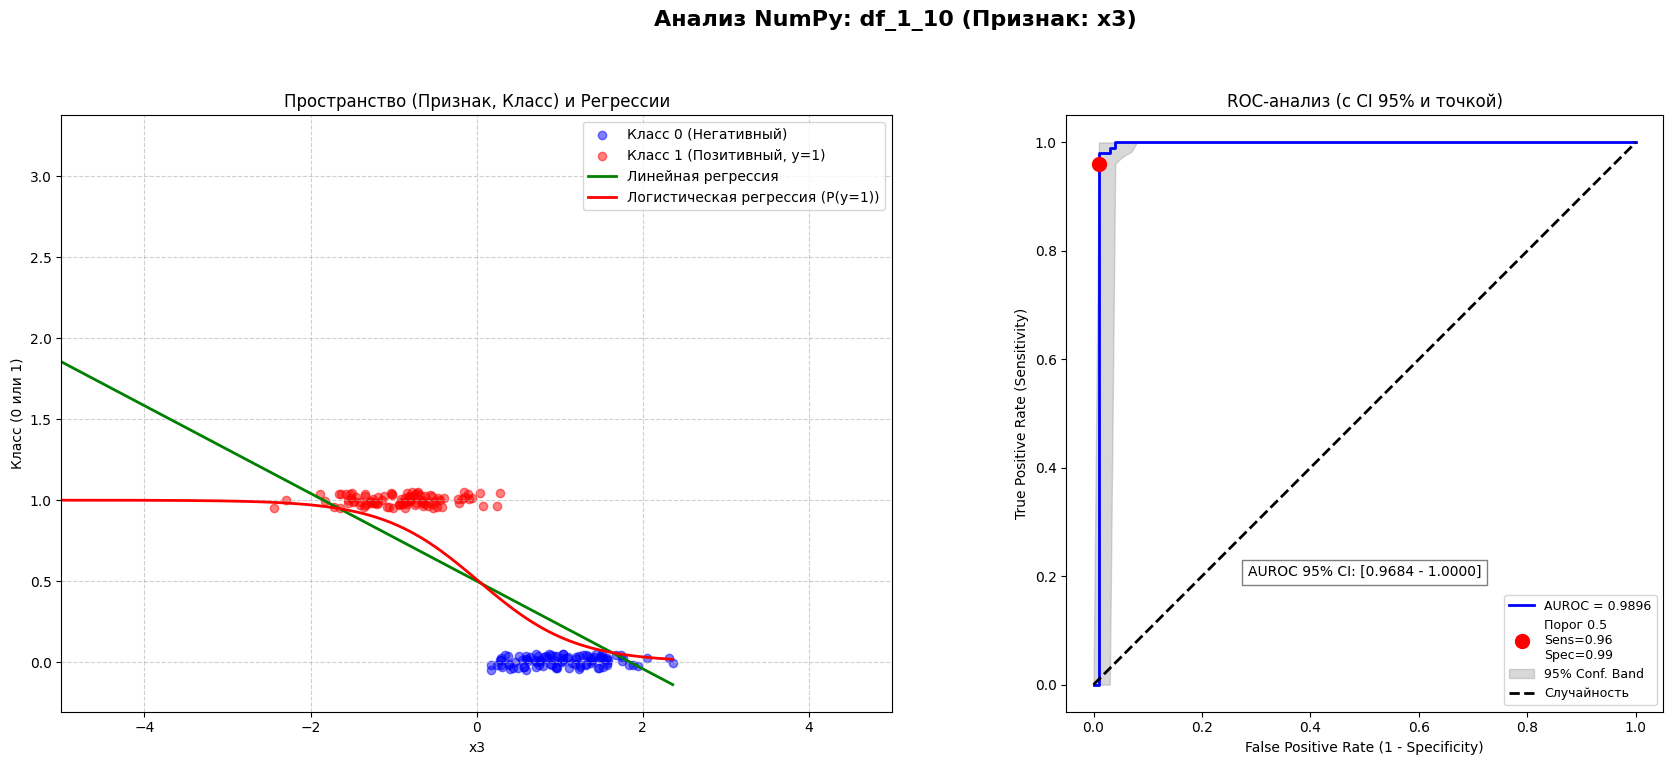


 АНАЛИЗ: df_1_100
Размер данных (Классы [0, 1]): (201, 1)
Запуск 1000 итераций бутстрэпа...
...Бутстрэп завершен.


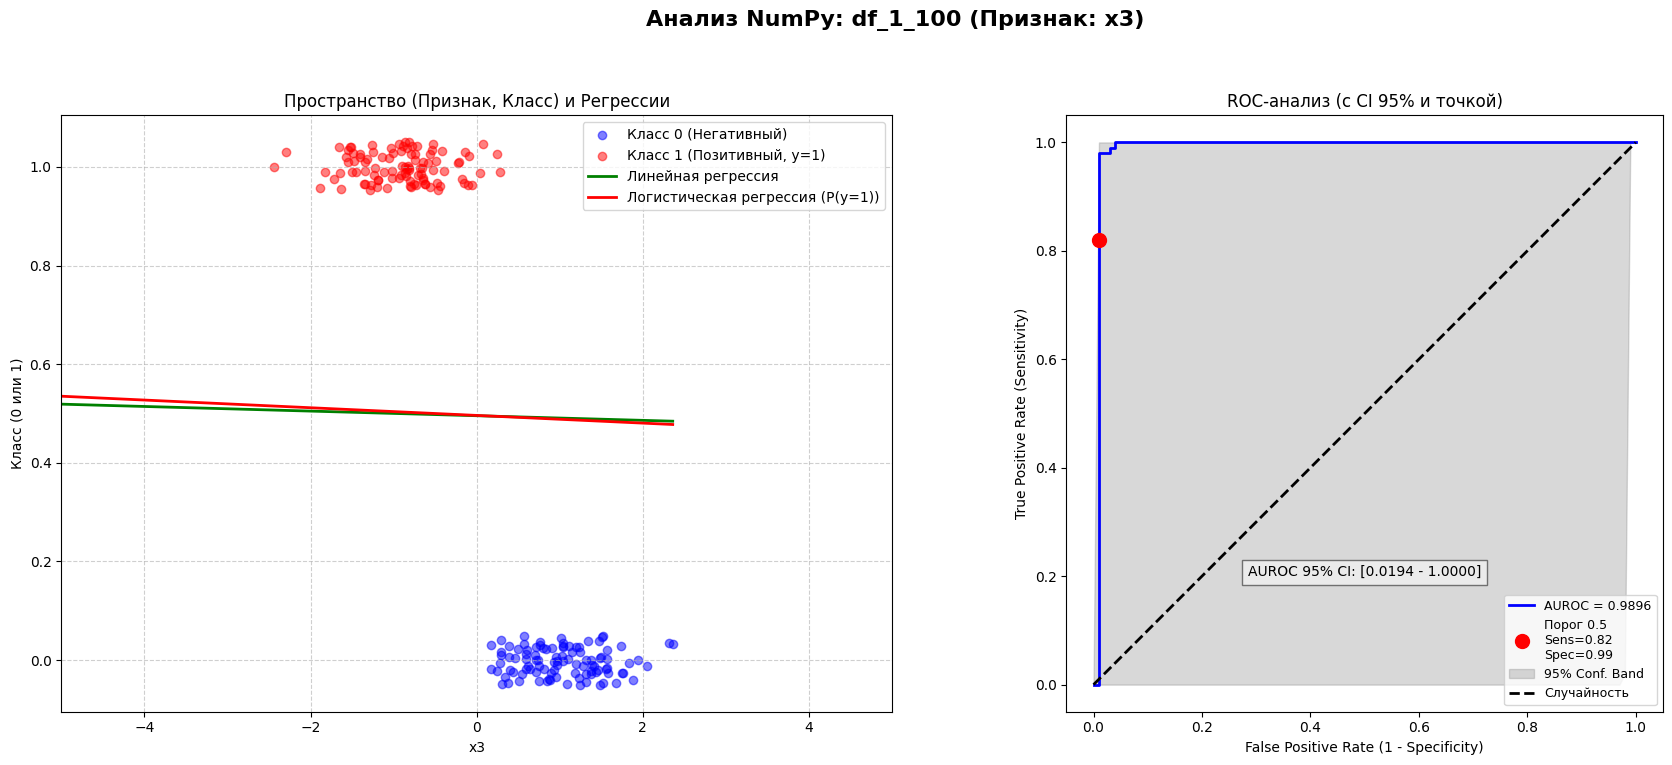


 АНАЛИЗ: df_10_1
Размер данных (Классы [0, 1]): (210, 1)
Запуск 1000 итераций бутстрэпа...
...Бутстрэп завершен.


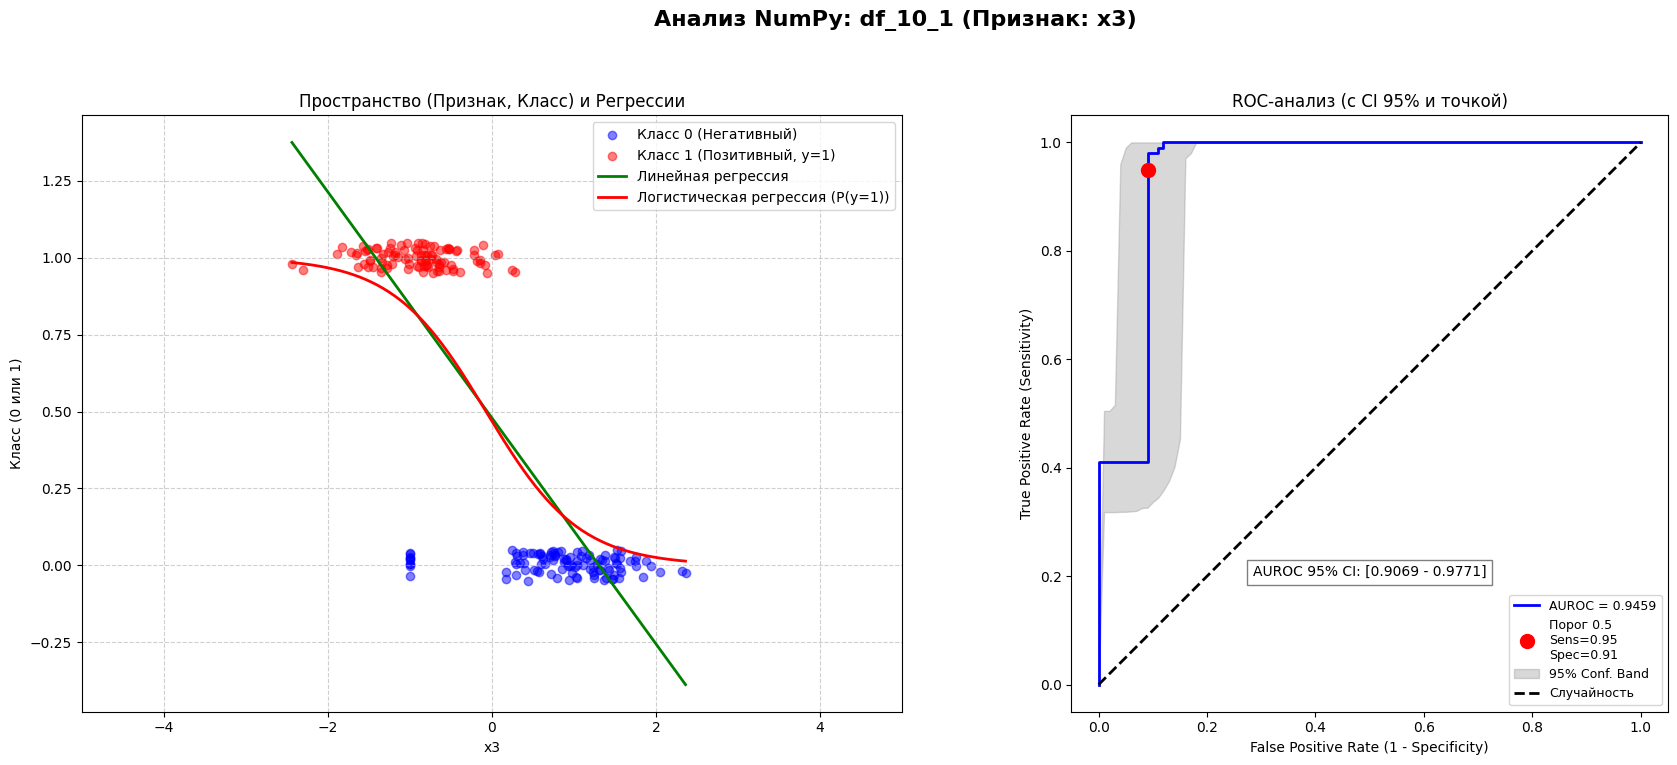


 АНАЛИЗ: df_10_10
Размер данных (Классы [0, 1]): (210, 1)
Запуск 1000 итераций бутстрэпа...
...Бутстрэп завершен.


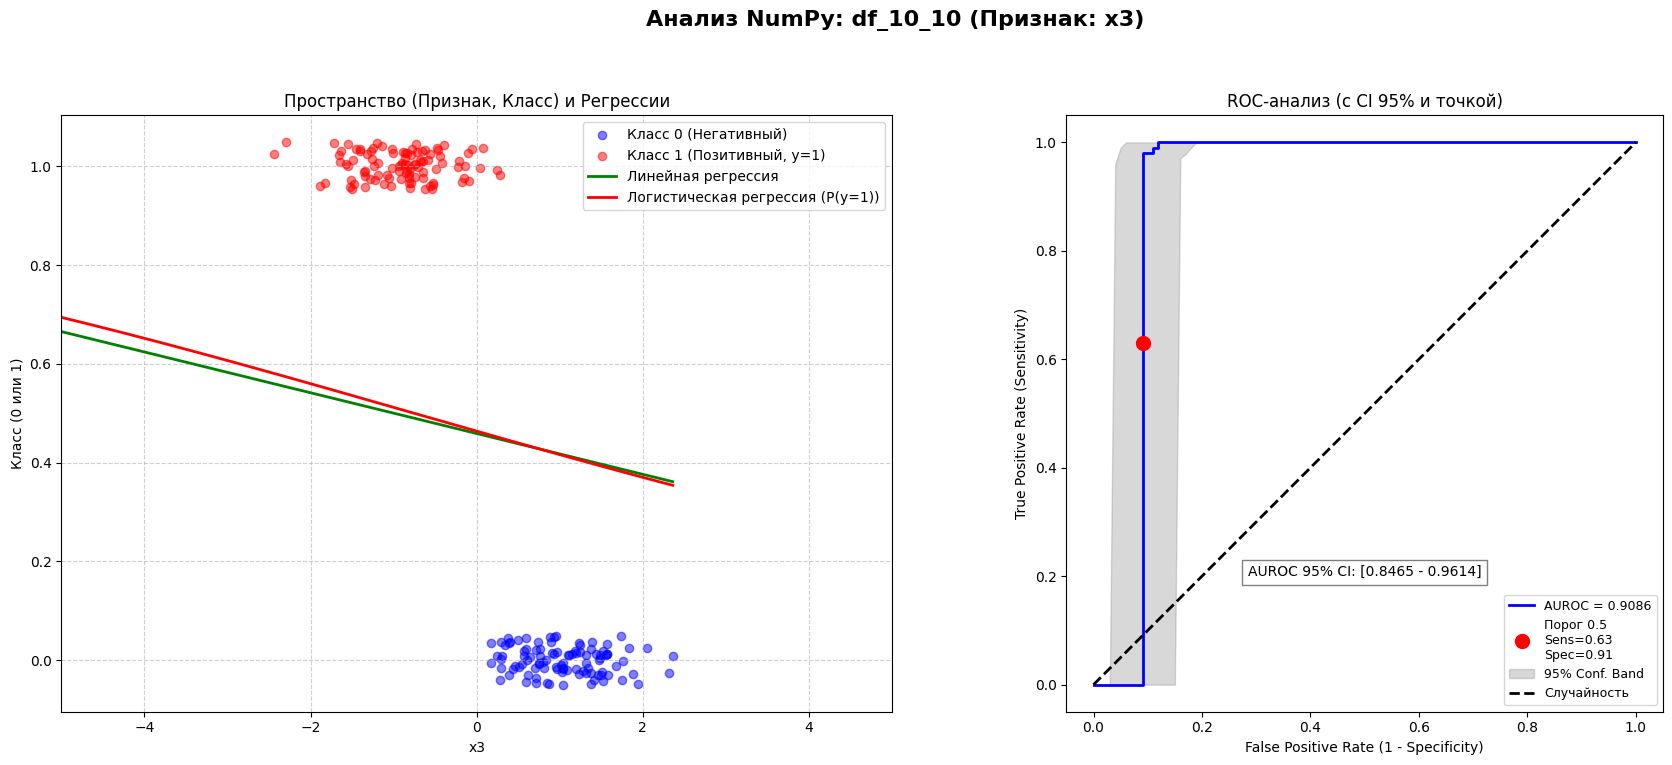


 АНАЛИЗ: df_10_100
Размер данных (Классы [0, 1]): (210, 1)
Запуск 1000 итераций бутстрэпа...
...Бутстрэп завершен.


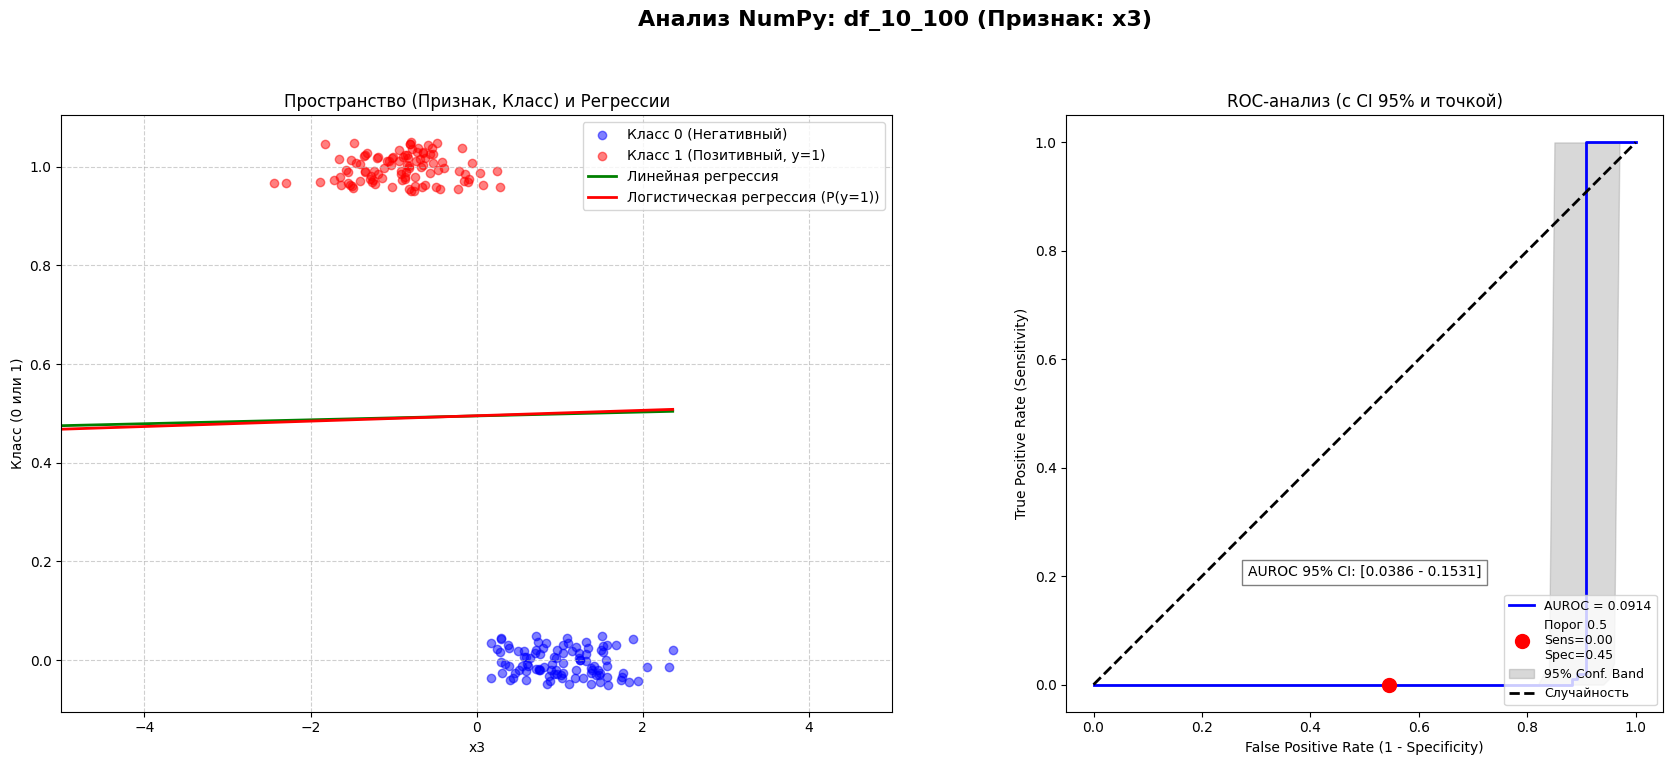


 АНАЛИЗ: df_100_1
Размер данных (Классы [0, 1]): (300, 1)
Запуск 1000 итераций бутстрэпа...
...Бутстрэп завершен.


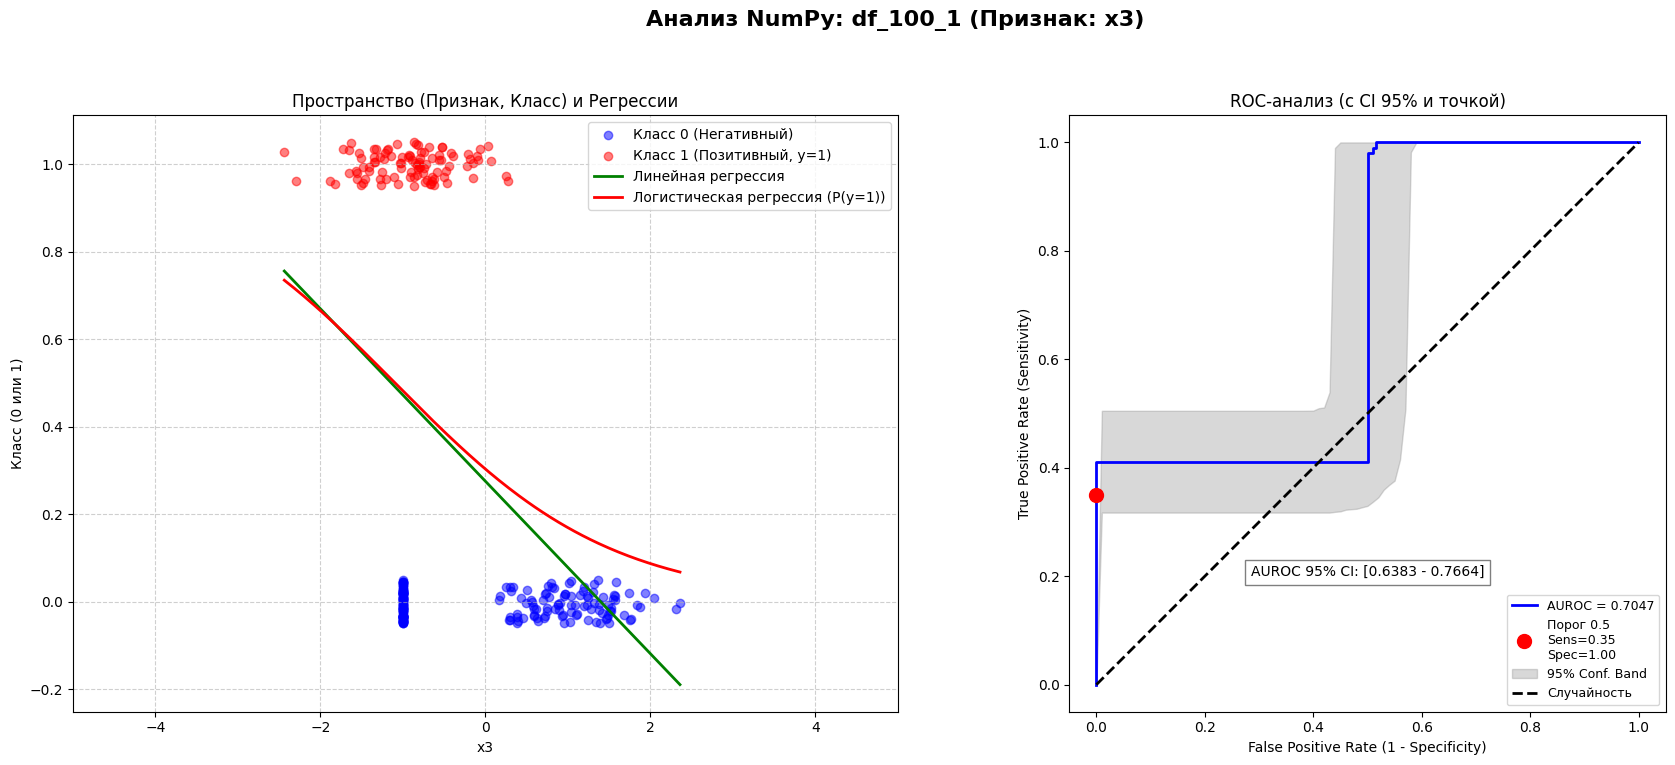


 АНАЛИЗ: df_100_10
Размер данных (Классы [0, 1]): (300, 1)
Запуск 1000 итераций бутстрэпа...
...Бутстрэп завершен.


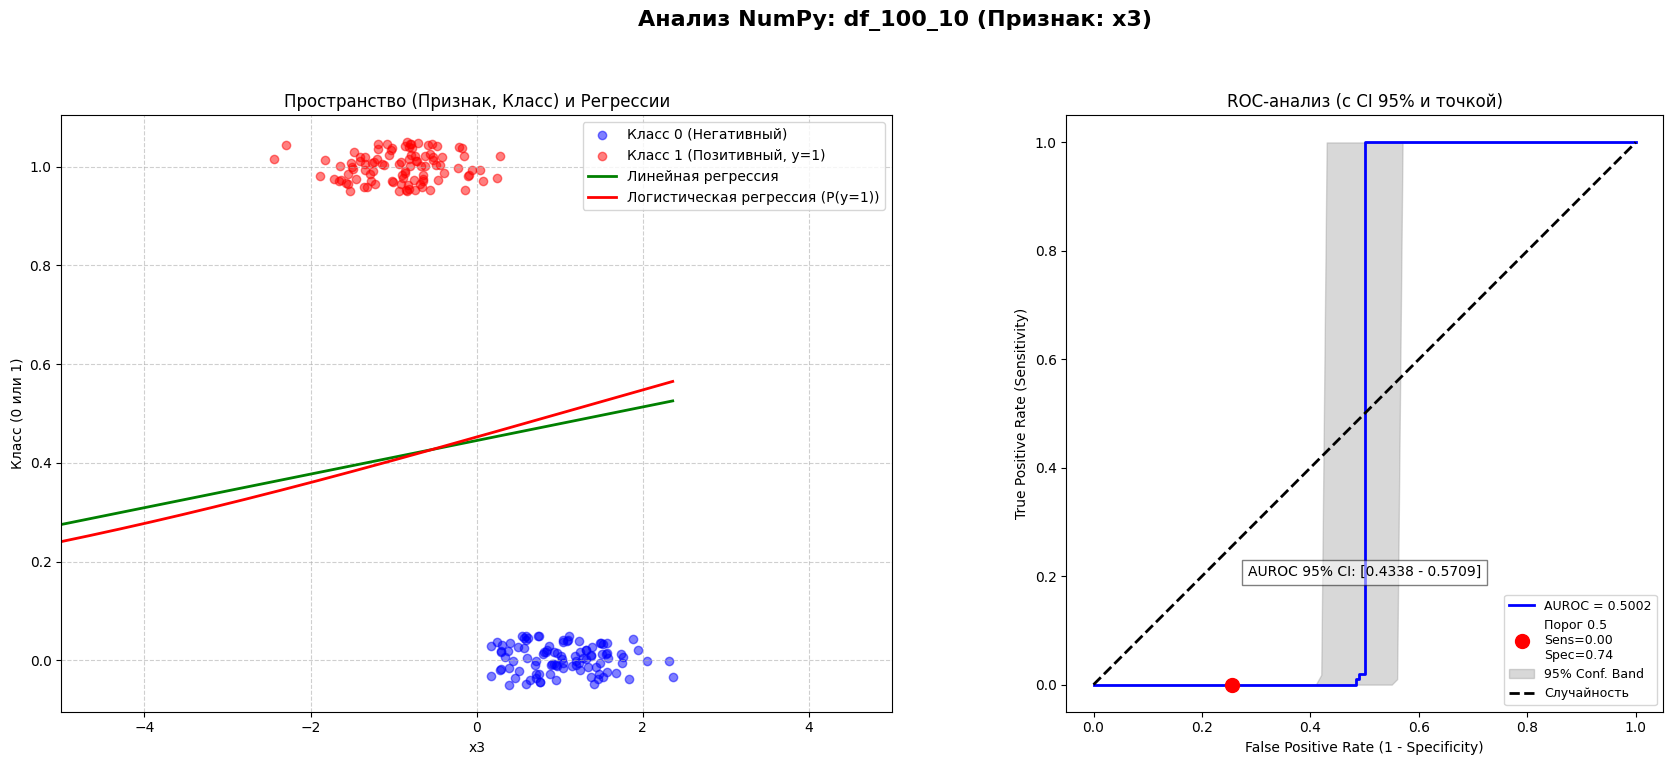


 АНАЛИЗ: df_100_100
Размер данных (Классы [0, 1]): (300, 1)
Запуск 1000 итераций бутстрэпа...
...Бутстрэп завершен.


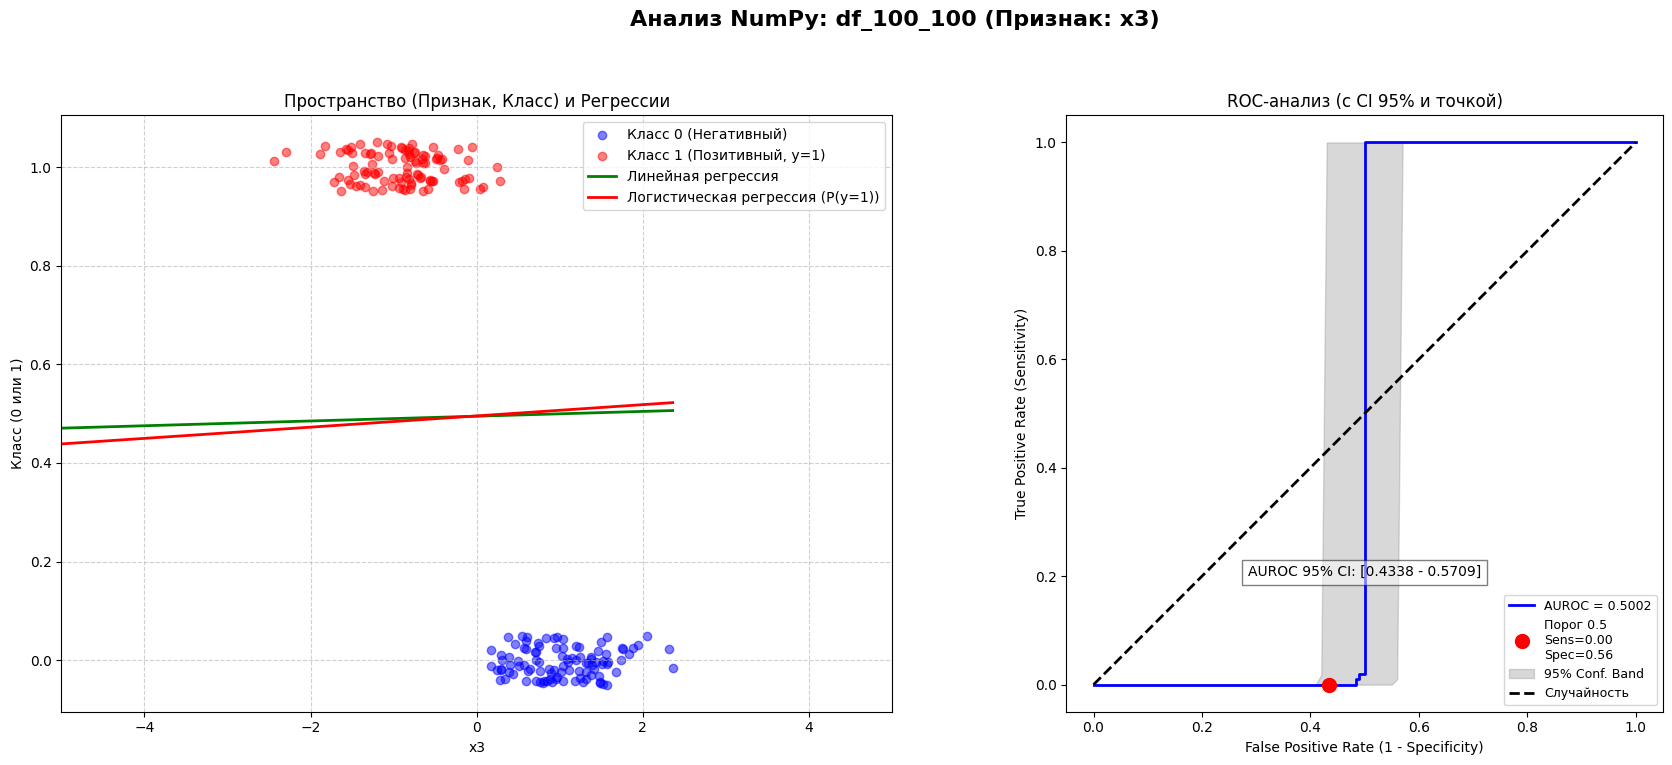

In [126]:
task3(
    all_dfs, 
    CLASSES_TO_ANALYZE, 
    feature_to_use=FEATURE_TO_USE, 
    n_bootstraps=1000, 
    positive_class=1
)

### task4

**Формулировка:** Для выбранной пары классов (включая класс с повторенными объектами) на первых четырех признаках вычислить уравнение множественной линейной регрессии, где Xi – признаки.
Используя полученное уравнение множественной линейной регрессии, на основе каждого из датасетов из списка (df, df_A_B) сформировать новые датасеты logdf,logdf_A_B, в каждом из которых есть только один признак Х, сформированный на основе соответствующего уравнения множественной линейной регрессии, а переменная Y –
определяет отнесение к классу.

In [129]:
def task4(all_datasets, classes_to_analyze, features_4d, positive_class):
    
    if positive_class not in classes_to_analyze:
        raise ValueError(f"Позитивный класс {positive_class} не найден в {classes_to_analyze}")
            
    log_dfs = {}

    for df_name, df_data in all_datasets.items():
        
        df_subset = df_data[df_data['cluster_id'].isin(classes_to_analyze)].copy()
        
        y = df_subset['cluster_id']
        X_4d = df_subset[features_4d].values 

        mlr_model = LinearRegression()
        mlr_model.fit(X_4d, y)
        
        new_single_feature = mlr_model.predict(X_4d)

        logdf = pd.DataFrame({
            'LinReg_Score': new_single_feature,
            'cluster_id': y         
        })
        
        log_dfs[df_name] = logdf
        
    return log_dfs

In [152]:
FEATURES_4D = ['x0', 'x1', 'x2', 'x3']

log_dfs= task4(
    all_datasets=all_dfs, 
    classes_to_analyze=CLASSES_TO_ANALYZE, 
    features_4d=FEATURES_4D, 
    positive_class=1
)
log_dfs['df'].head()

LinReg_Score  cluster_id
0      0.892801         1.0
1      1.127871         1.0
4     -0.049376         0.0
6     -0.031873         0.0
7      0.001672         0.0

### task5

**Формулировка:** 
1) Для каждого из датасетов из списка  (logdf, logdf_A_B) в своем пространстве <br> Х-Y(количественный признак-класс) построить и визуализировать:
    - объекты, 
    - линию линейнойрегрессии,
    - линию логистической регрессии. 
    
*Регрессии строить на паре Х-Y(количественный признак-класс).*

2) Оценить качество работы полученных на основе логистической регрессии классификаторов, используя ROC кривые, восстановив на графике ROC-кривых определенную логистической регрессией точку классификации Sensitivity-Specificity и оценные бутстрепом доверительные интервалы CI95 (n=1000).

*Все полученные графики возможно расположить в две колонки: левая колонка –
визуализация пространства и регрессий, правая – графики с ROC кривой и точкой.*

Маппинг классов: {0: 0, 1: 1} (Позитивный = 1)

 АНАЛИЗ: df
Размер данных (Классы [0, 1]): (200, 1)
Запуск 1000 итераций бутстрэпа...
...Бутстрэп завершен.


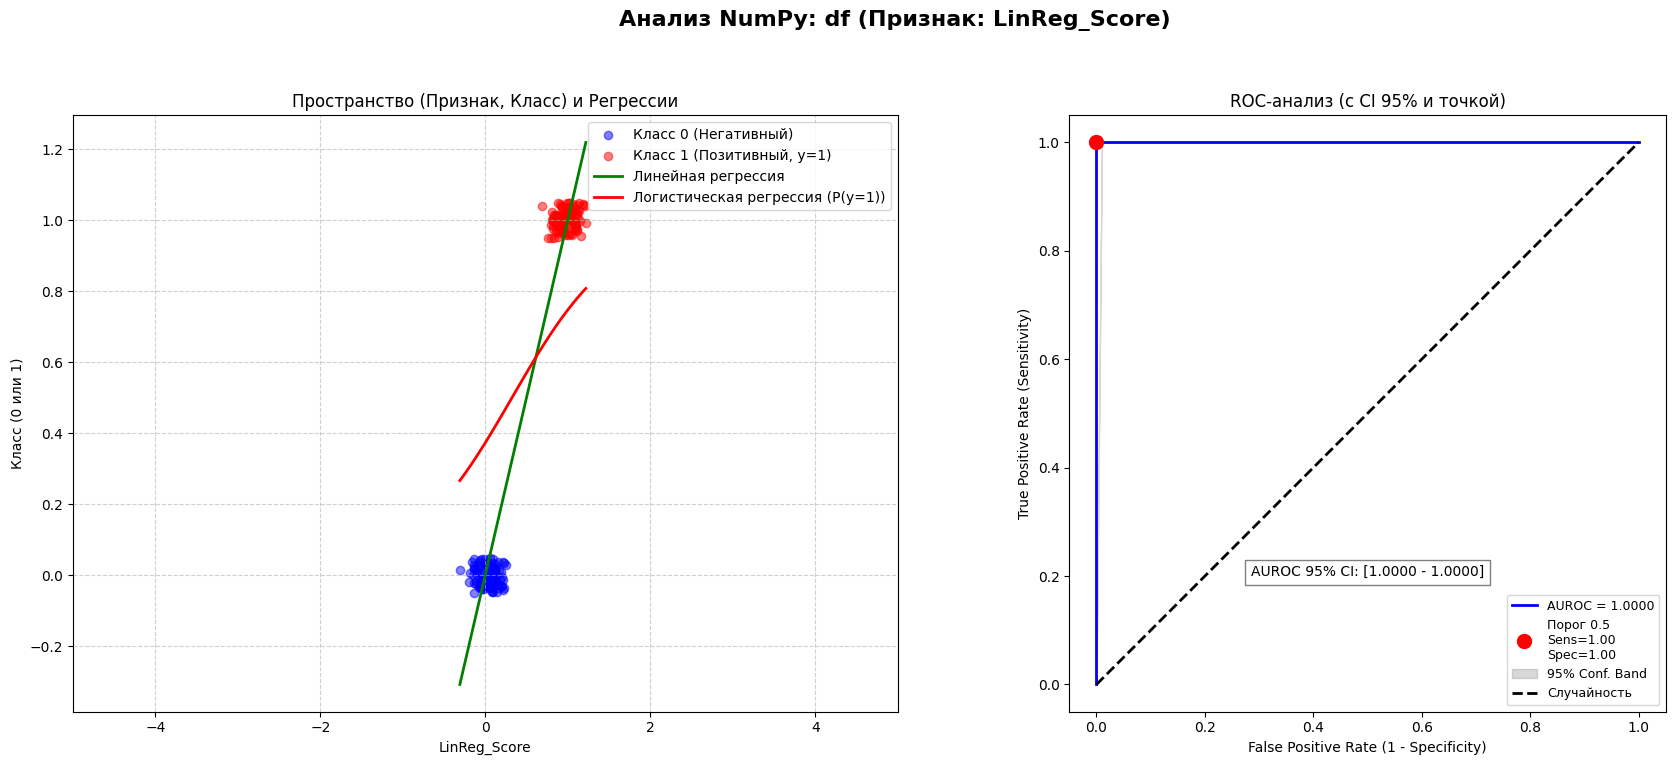


 АНАЛИЗ: df_1_1
Размер данных (Классы [0, 1]): (201, 1)
Запуск 1000 итераций бутстрэпа...
...Бутстрэп завершен.


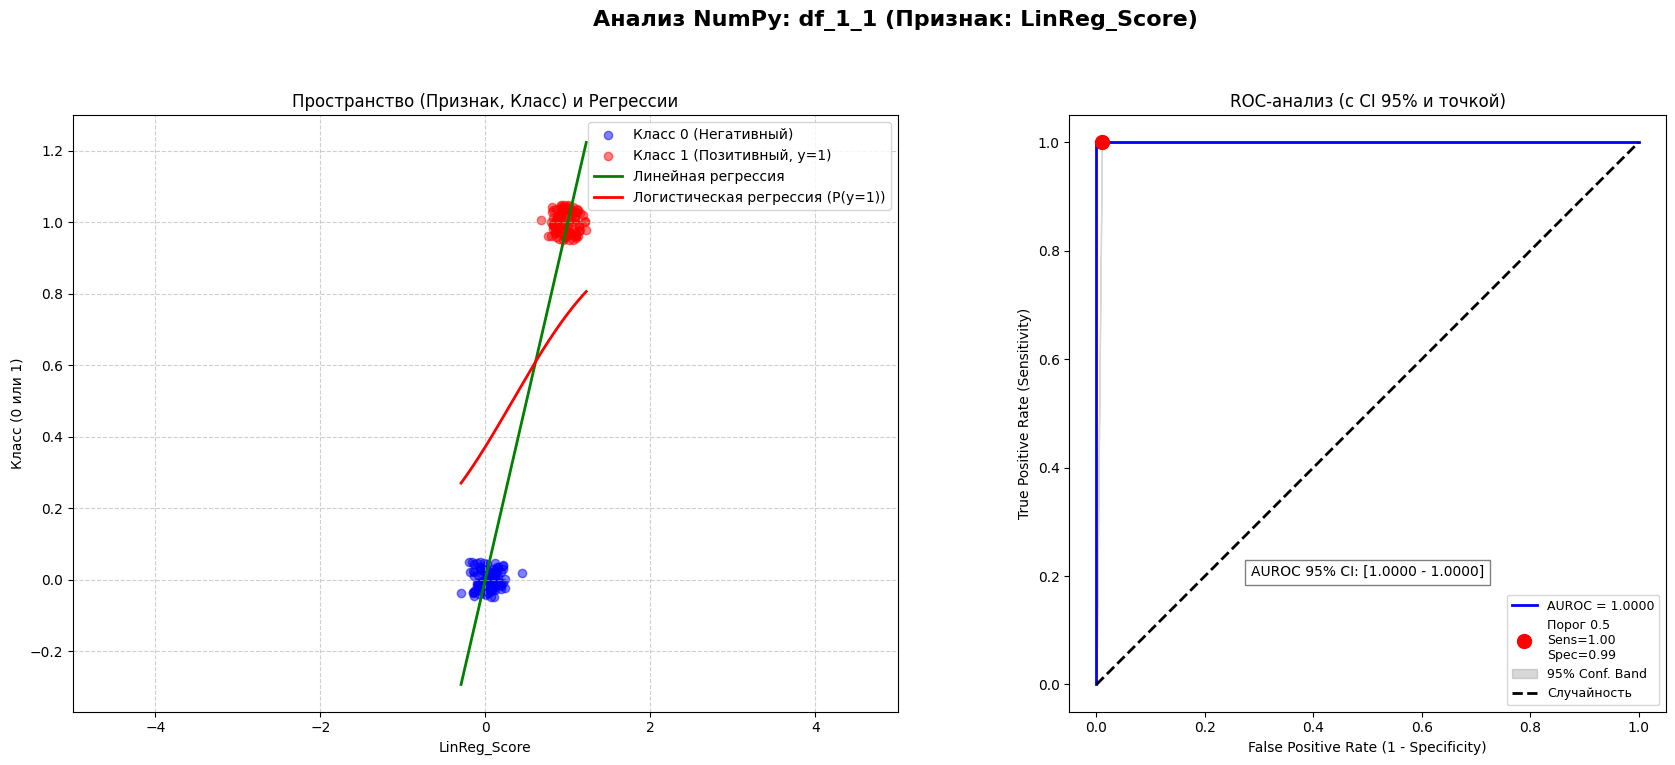


 АНАЛИЗ: df_1_10
Размер данных (Классы [0, 1]): (201, 1)
Запуск 1000 итераций бутстрэпа...
...Бутстрэп завершен.


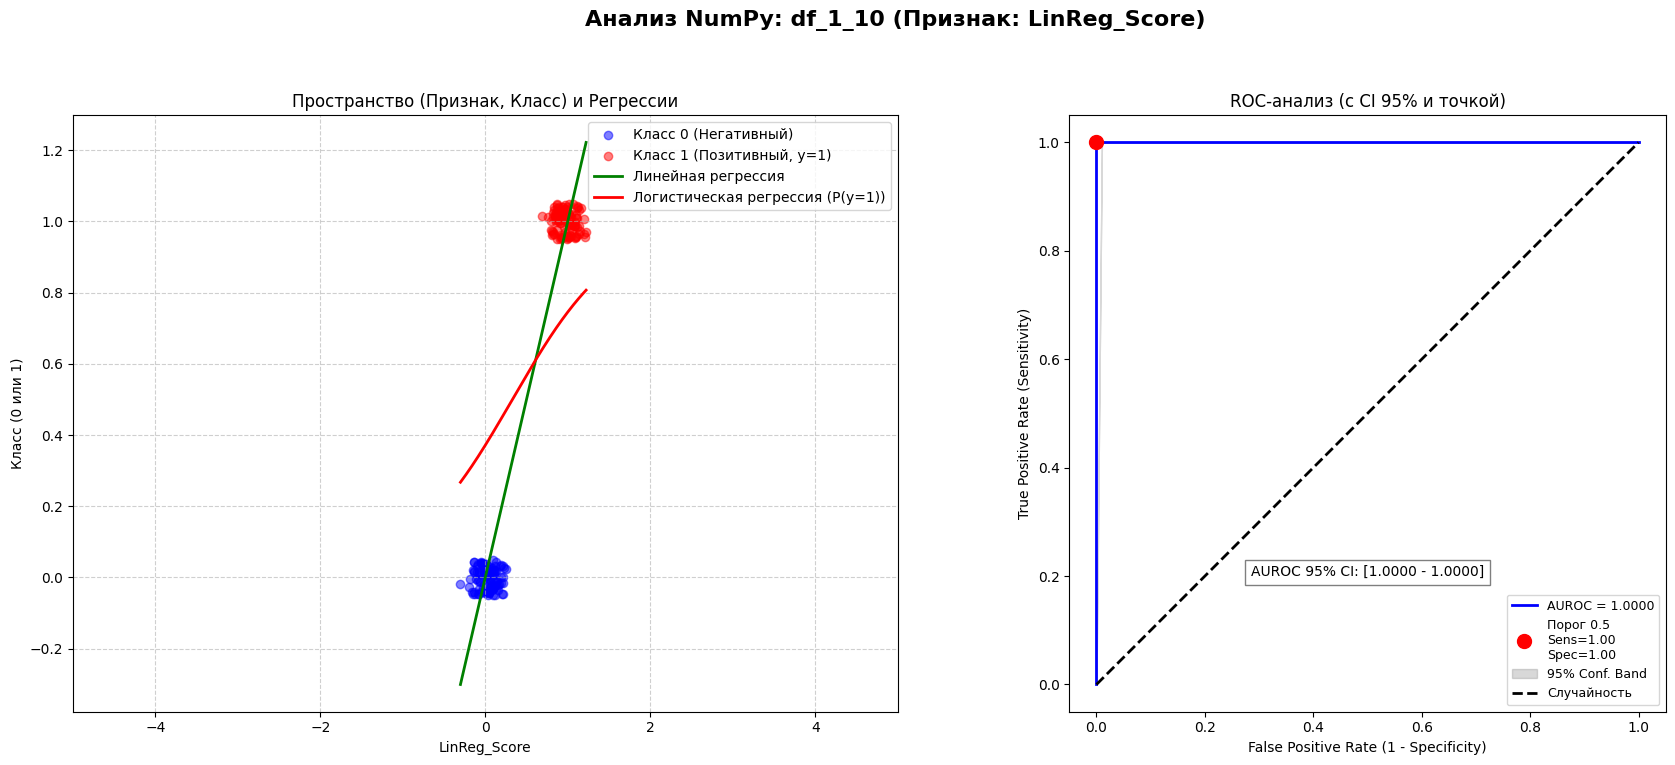


 АНАЛИЗ: df_1_100
Размер данных (Классы [0, 1]): (201, 1)
Запуск 1000 итераций бутстрэпа...
...Бутстрэп завершен.


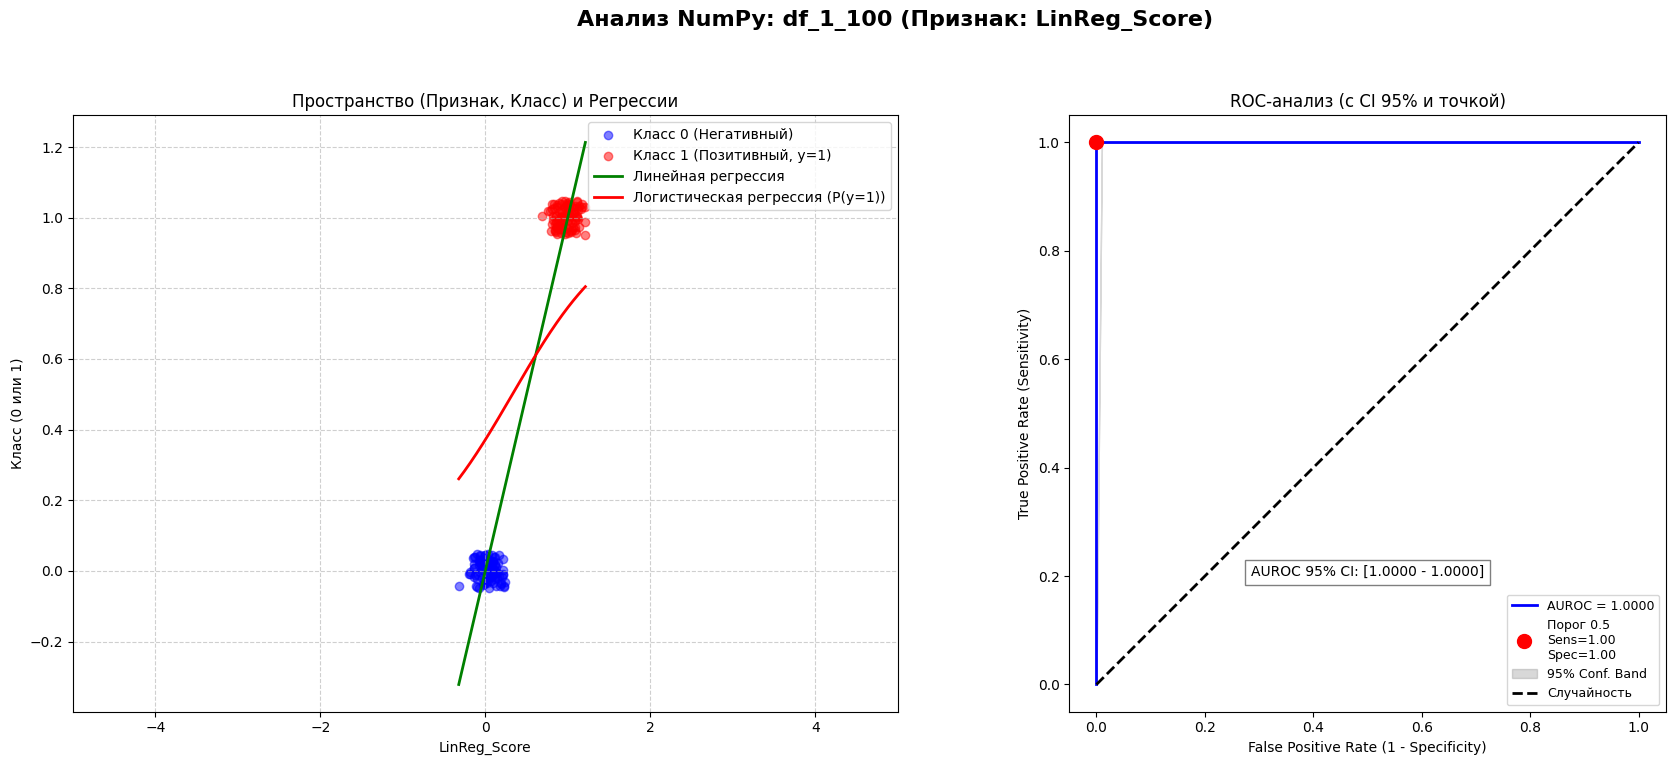


 АНАЛИЗ: df_10_1
Размер данных (Классы [0, 1]): (210, 1)
Запуск 1000 итераций бутстрэпа...
...Бутстрэп завершен.


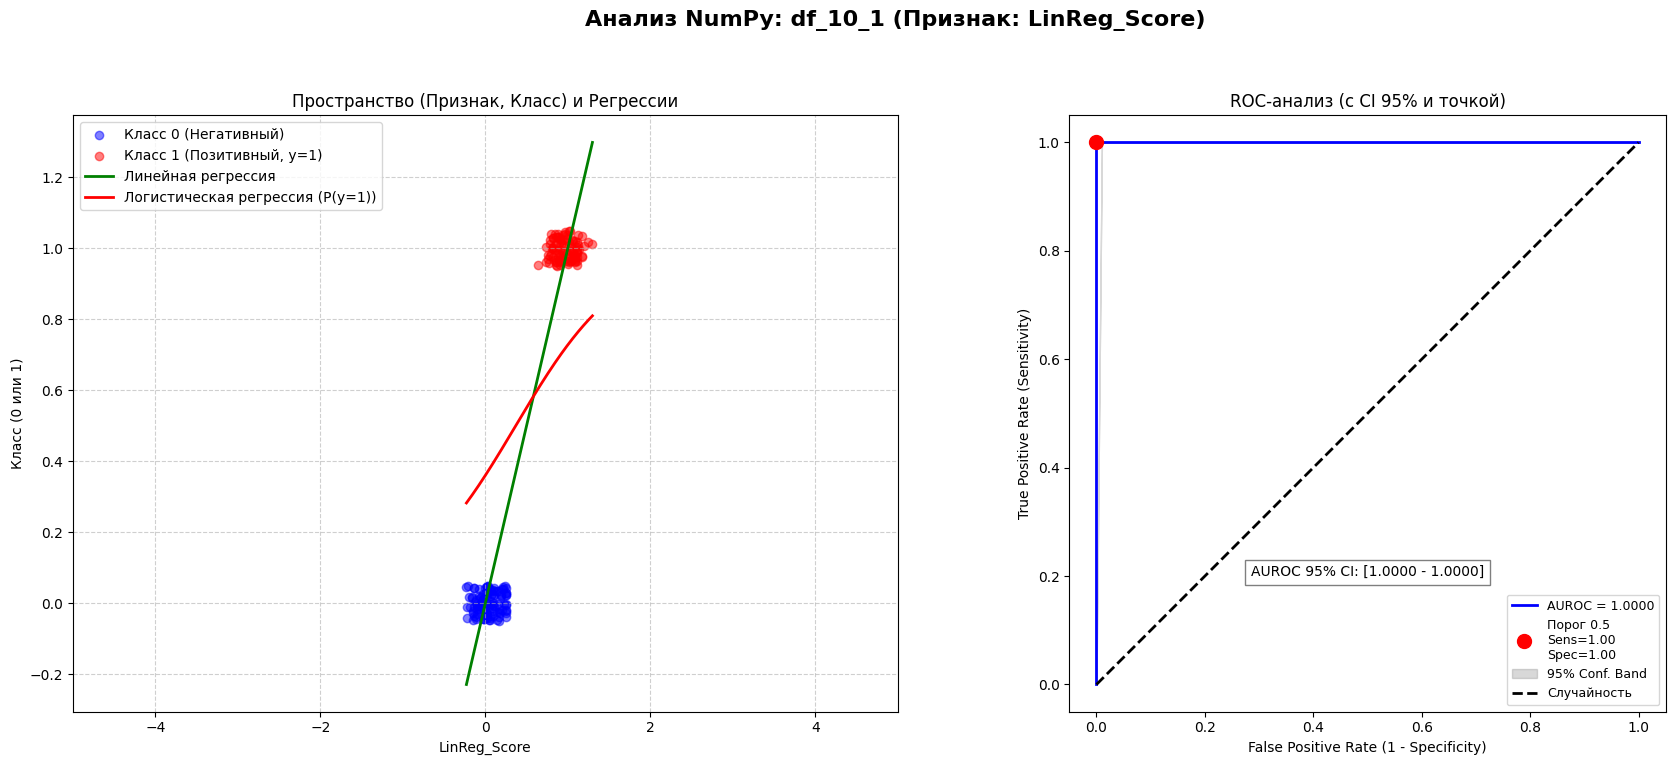


 АНАЛИЗ: df_10_10
Размер данных (Классы [0, 1]): (210, 1)
Запуск 1000 итераций бутстрэпа...
...Бутстрэп завершен.


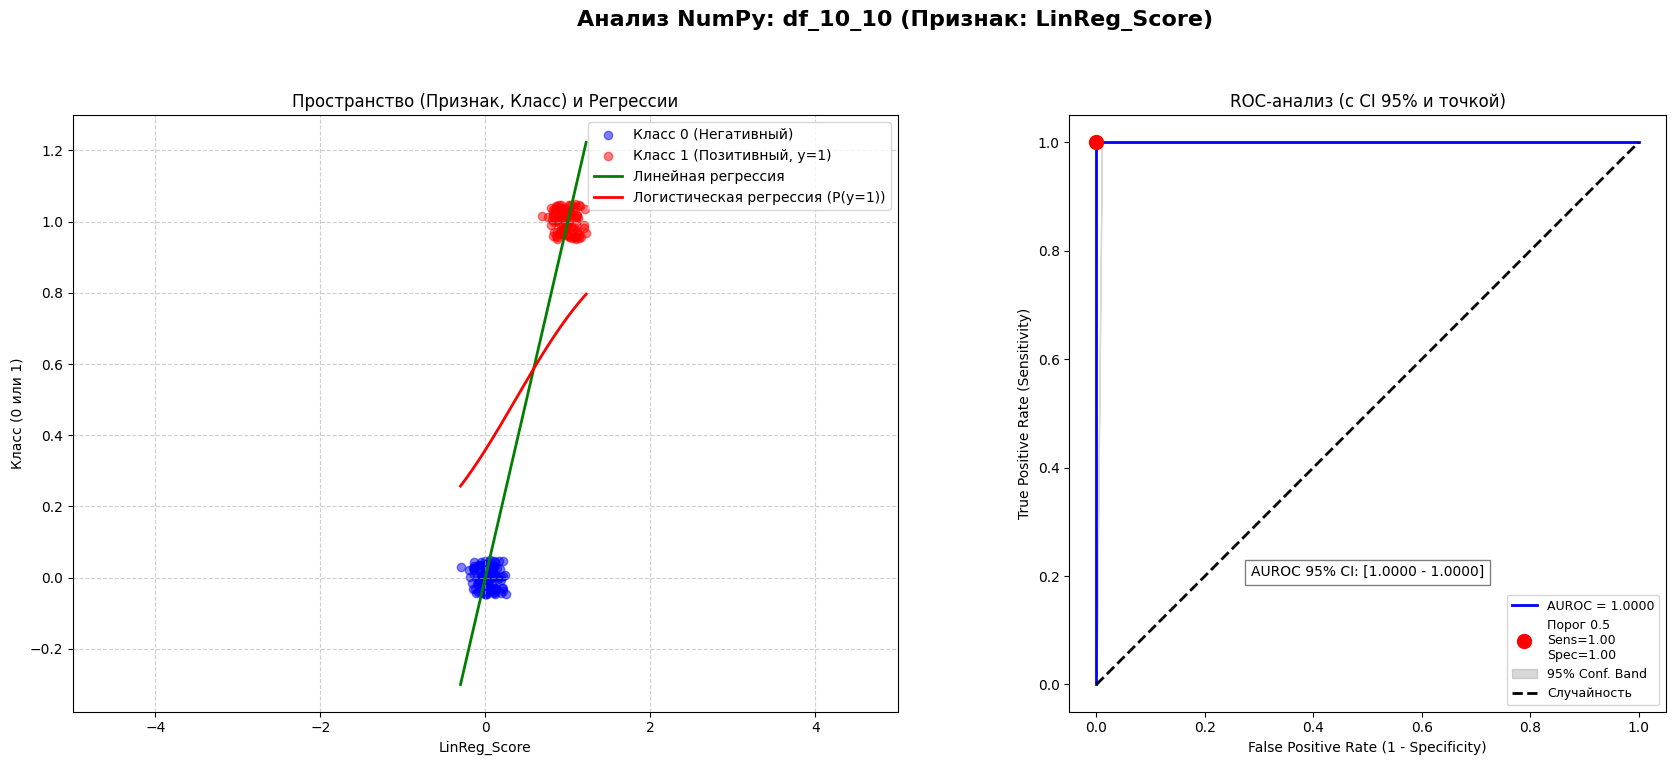


 АНАЛИЗ: df_10_100
Размер данных (Классы [0, 1]): (210, 1)
Запуск 1000 итераций бутстрэпа...
...Бутстрэп завершен.


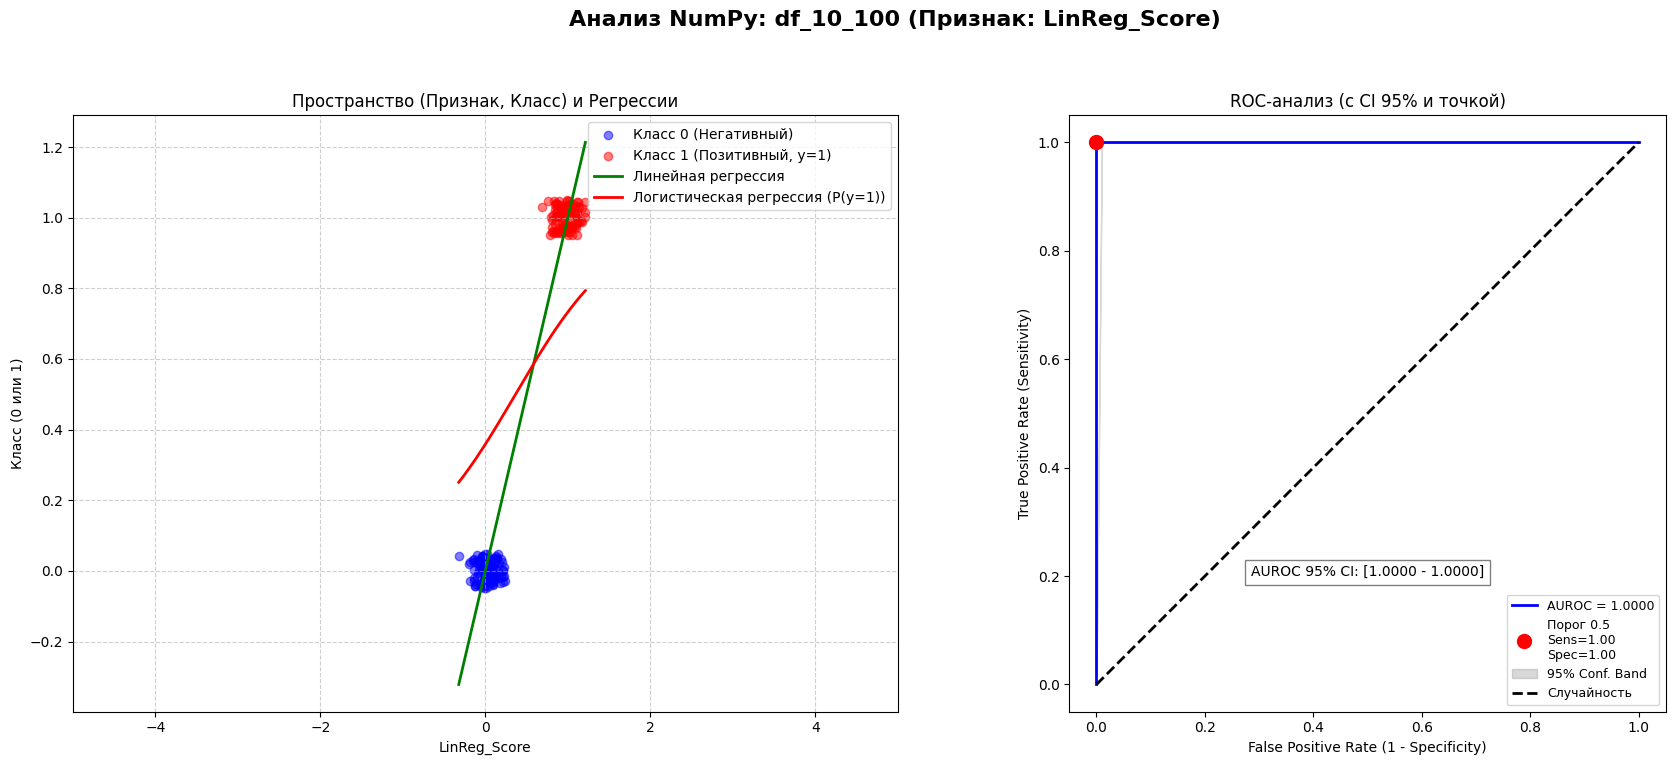


 АНАЛИЗ: df_100_1
Размер данных (Классы [0, 1]): (300, 1)
Запуск 1000 итераций бутстрэпа...
...Бутстрэп завершен.


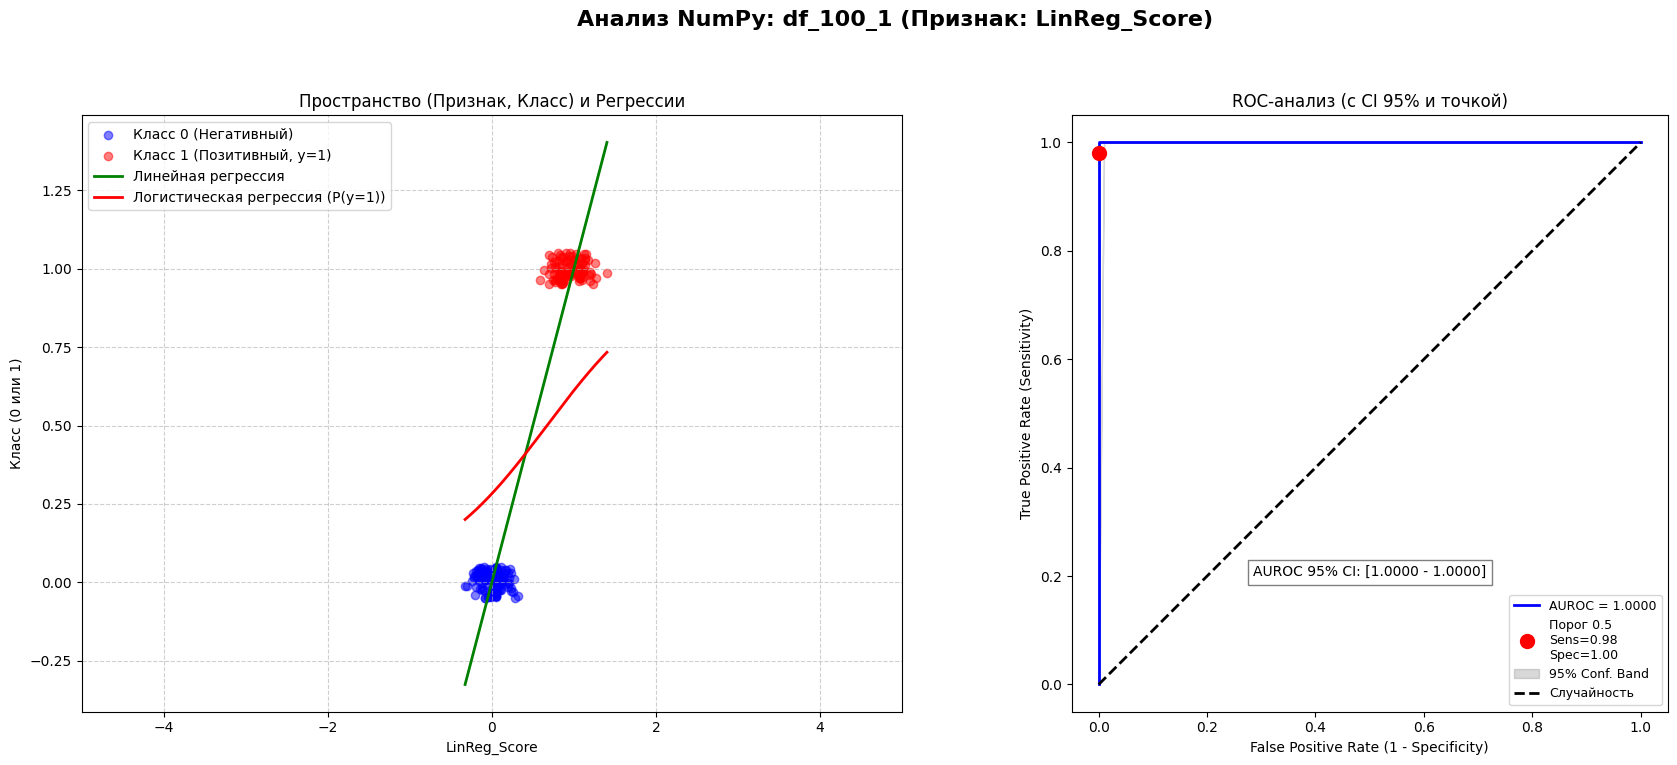


 АНАЛИЗ: df_100_10
Размер данных (Классы [0, 1]): (300, 1)
Запуск 1000 итераций бутстрэпа...
...Бутстрэп завершен.


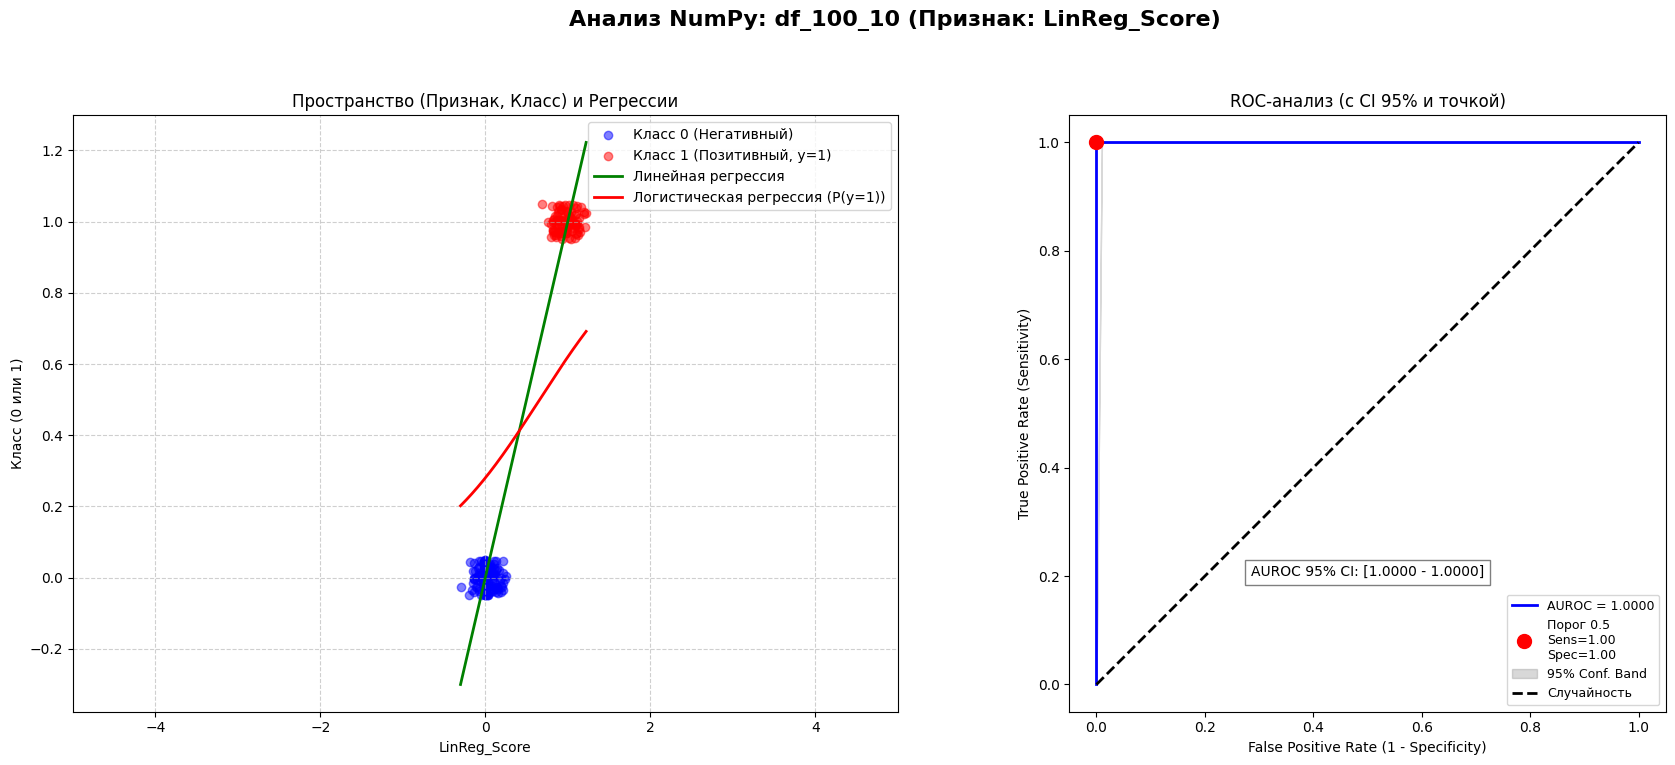


 АНАЛИЗ: df_100_100
Размер данных (Классы [0, 1]): (300, 1)
Запуск 1000 итераций бутстрэпа...
...Бутстрэп завершен.


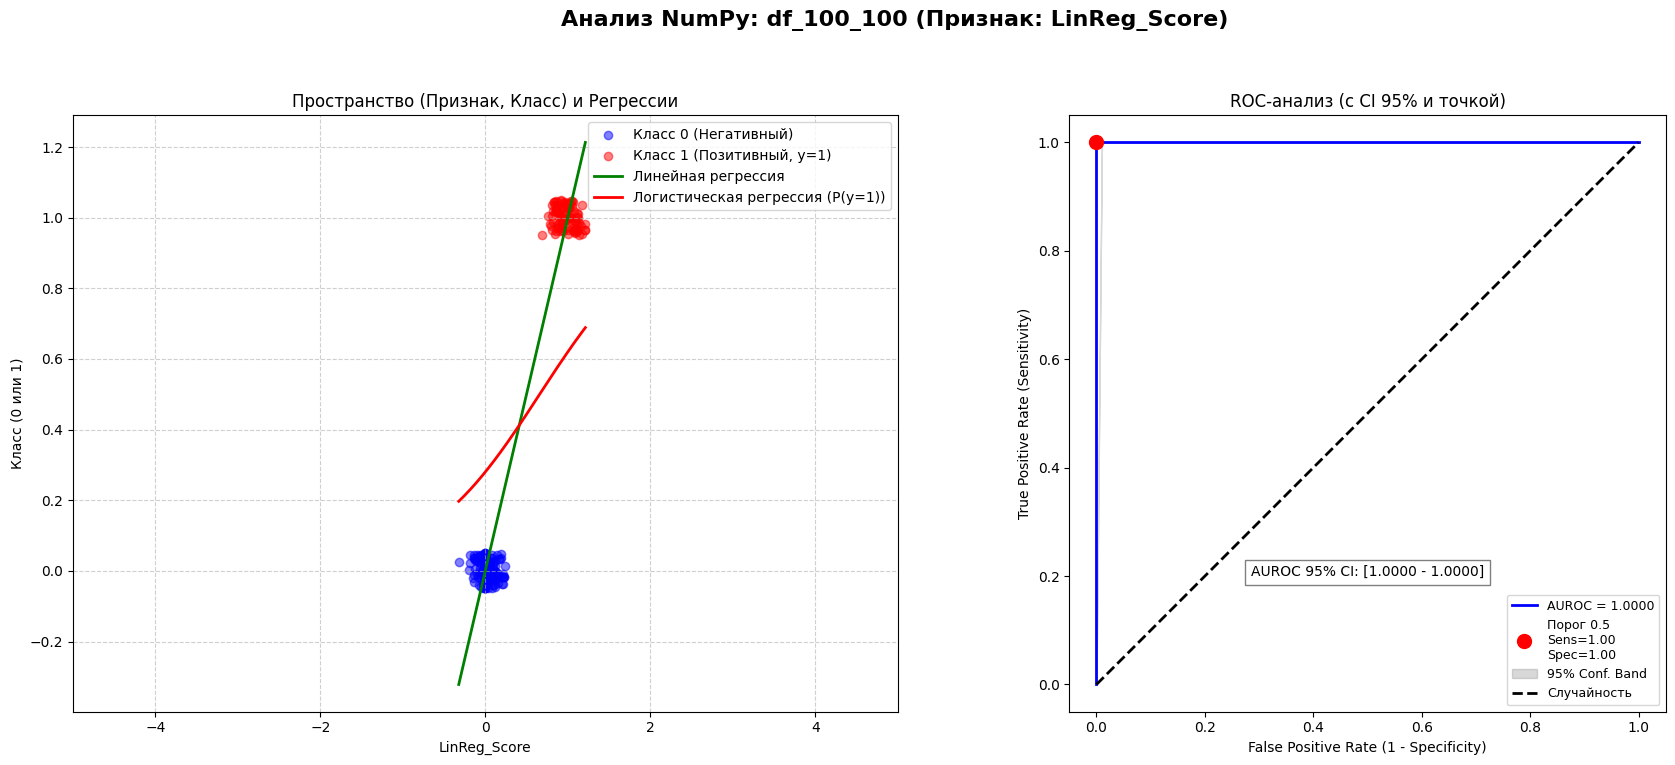

In [132]:
FEATURE_TO_USE = "LinReg_Score"

task3(
    log_dfs, 
    CLASSES_TO_ANALYZE, 
    feature_to_use=FEATURE_TO_USE, 
    n_bootstraps=1000, 
    positive_class=1
)

### task6

**Формулировка:** Для выбранной пары классов (включая класс с повторенными объектами), визуализировать один из датасетов df_A_B на всех парах переменных, построив на графиках:
 1) объекты
 2) линии множественной линейной регрессии 
 3) разделение классов на основе логистической регрессии решающей функцией с contour_plot уровнями классификации c подписанной вероятностью отнесения к целевому классу

In [149]:
def task6(df_single, features_4d, classes_to_analyze, positive_class):

    if positive_class not in classes_to_analyze:
        raise ValueError(f"Позитивный класс {positive_class} не найден в {classes_to_analyze}")
        
    c_pos = positive_class
    c_neg = classes_to_analyze[0] if classes_to_analyze[1] == c_pos else classes_to_analyze[1]
    class_map = {c_neg: 0, c_pos: 1}
    
    df_subset = df_single[df_single['cluster_id'].isin(classes_to_analyze)].copy()
    df_subset['cluster_binary'] = df_subset['cluster_id'].map(class_map)
    y_binary = df_subset['cluster_binary'].values
    
    n_features = len(features_4d)
    
    fig, axes = plt.subplots(n_features, n_features, figsize=(20, 20))
    fig.suptitle(f"Анализ {n_features}x{n_features} (LogReg Contour + LinReg Line)", fontsize=20, weight='bold')

    for i in range(n_features): 
        for j in range(n_features): 
            
            ax = axes[i, j]
            feat_i = features_4d[i]
            feat_j = features_4d[j]
            
            if i == j:
                
                data= df_subset[feat_i]
                
                data_neg = data[y_binary == 0]
                data_pos = data[y_binary == 1]
                
                ax.hist(data_neg, color='blue', alpha=0.5, label=f'Класс {c_neg}', bins='auto')
                ax.hist(data_pos, color='red', alpha=0.5, label=f'Класс {c_pos}', bins='auto')
                                
                ax.set_title(feat_i, fontsize=14, weight='bold')
                ax.legend(fontsize='small')
                continue 

            X_j = df_subset[feat_j]
            X_i = df_subset[feat_i]
            X_2d = df_subset[[feat_j, feat_i]].values
            
            plot_mask = (X_j > -5) & (X_i > -5)
            
            ax.scatter(X_j[plot_mask & (y_binary == 0)], X_i[plot_mask & (y_binary == 0)], 
                       c='blue', alpha=0.5, label=f'Класс {c_neg}')
            ax.scatter(X_j[plot_mask & (y_binary == 1)], X_i[plot_mask & (y_binary == 1)], 
                       c='red', alpha=0.5, label=f'Класс {c_pos}')
            
            log_reg = BinaryLogisticRegression().fit(X_2d, y_binary, epochs=200) 
            
            x_min, x_max = -5, 5
            y_min, y_max = -5, 5
            xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50), 
                                 np.linspace(y_min, y_max, 50))
            
            grid_points = np.c_[xx.ravel(), yy.ravel()]
            Z_log = log_reg.predict_proba(grid_points)[:, 1]
            Z_log = Z_log.reshape(xx.shape)
            
            ax.contourf(xx, yy, Z_log, cmap='coolwarm', alpha=0.3, levels=np.linspace(0, 1, 11))
            
            contour_levels = [0.25, 0.5, 0.75]
            CS = ax.contour(xx, yy, Z_log, levels=contour_levels, colors='black', linestyles='--')
            ax.clabel(CS, inline=True, fontsize=10, fmt='P(y=1)=%.2f')

            lin_reg = LinearRegression().fit(X_2d, y_binary)
            w = lin_reg.weights 
            
            x_line_j = np.array([x_min, x_max]) 
            y_line_i = (0.5 - w[0] - w[1]*x_line_j) / w[2] 
            
            ax.plot(x_line_j, y_line_i, 'g-', lw=2, label='LinReg Boundary (y=0.5)')
            
            ax.set_xlabel(feat_j, fontsize=12)
            ax.set_ylabel(feat_i, fontsize=12)
            ax.legend(loc='lower left', fontsize='small')
            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_min, y_max)
            ax.grid(True, linestyle=':', alpha=0.5)

    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

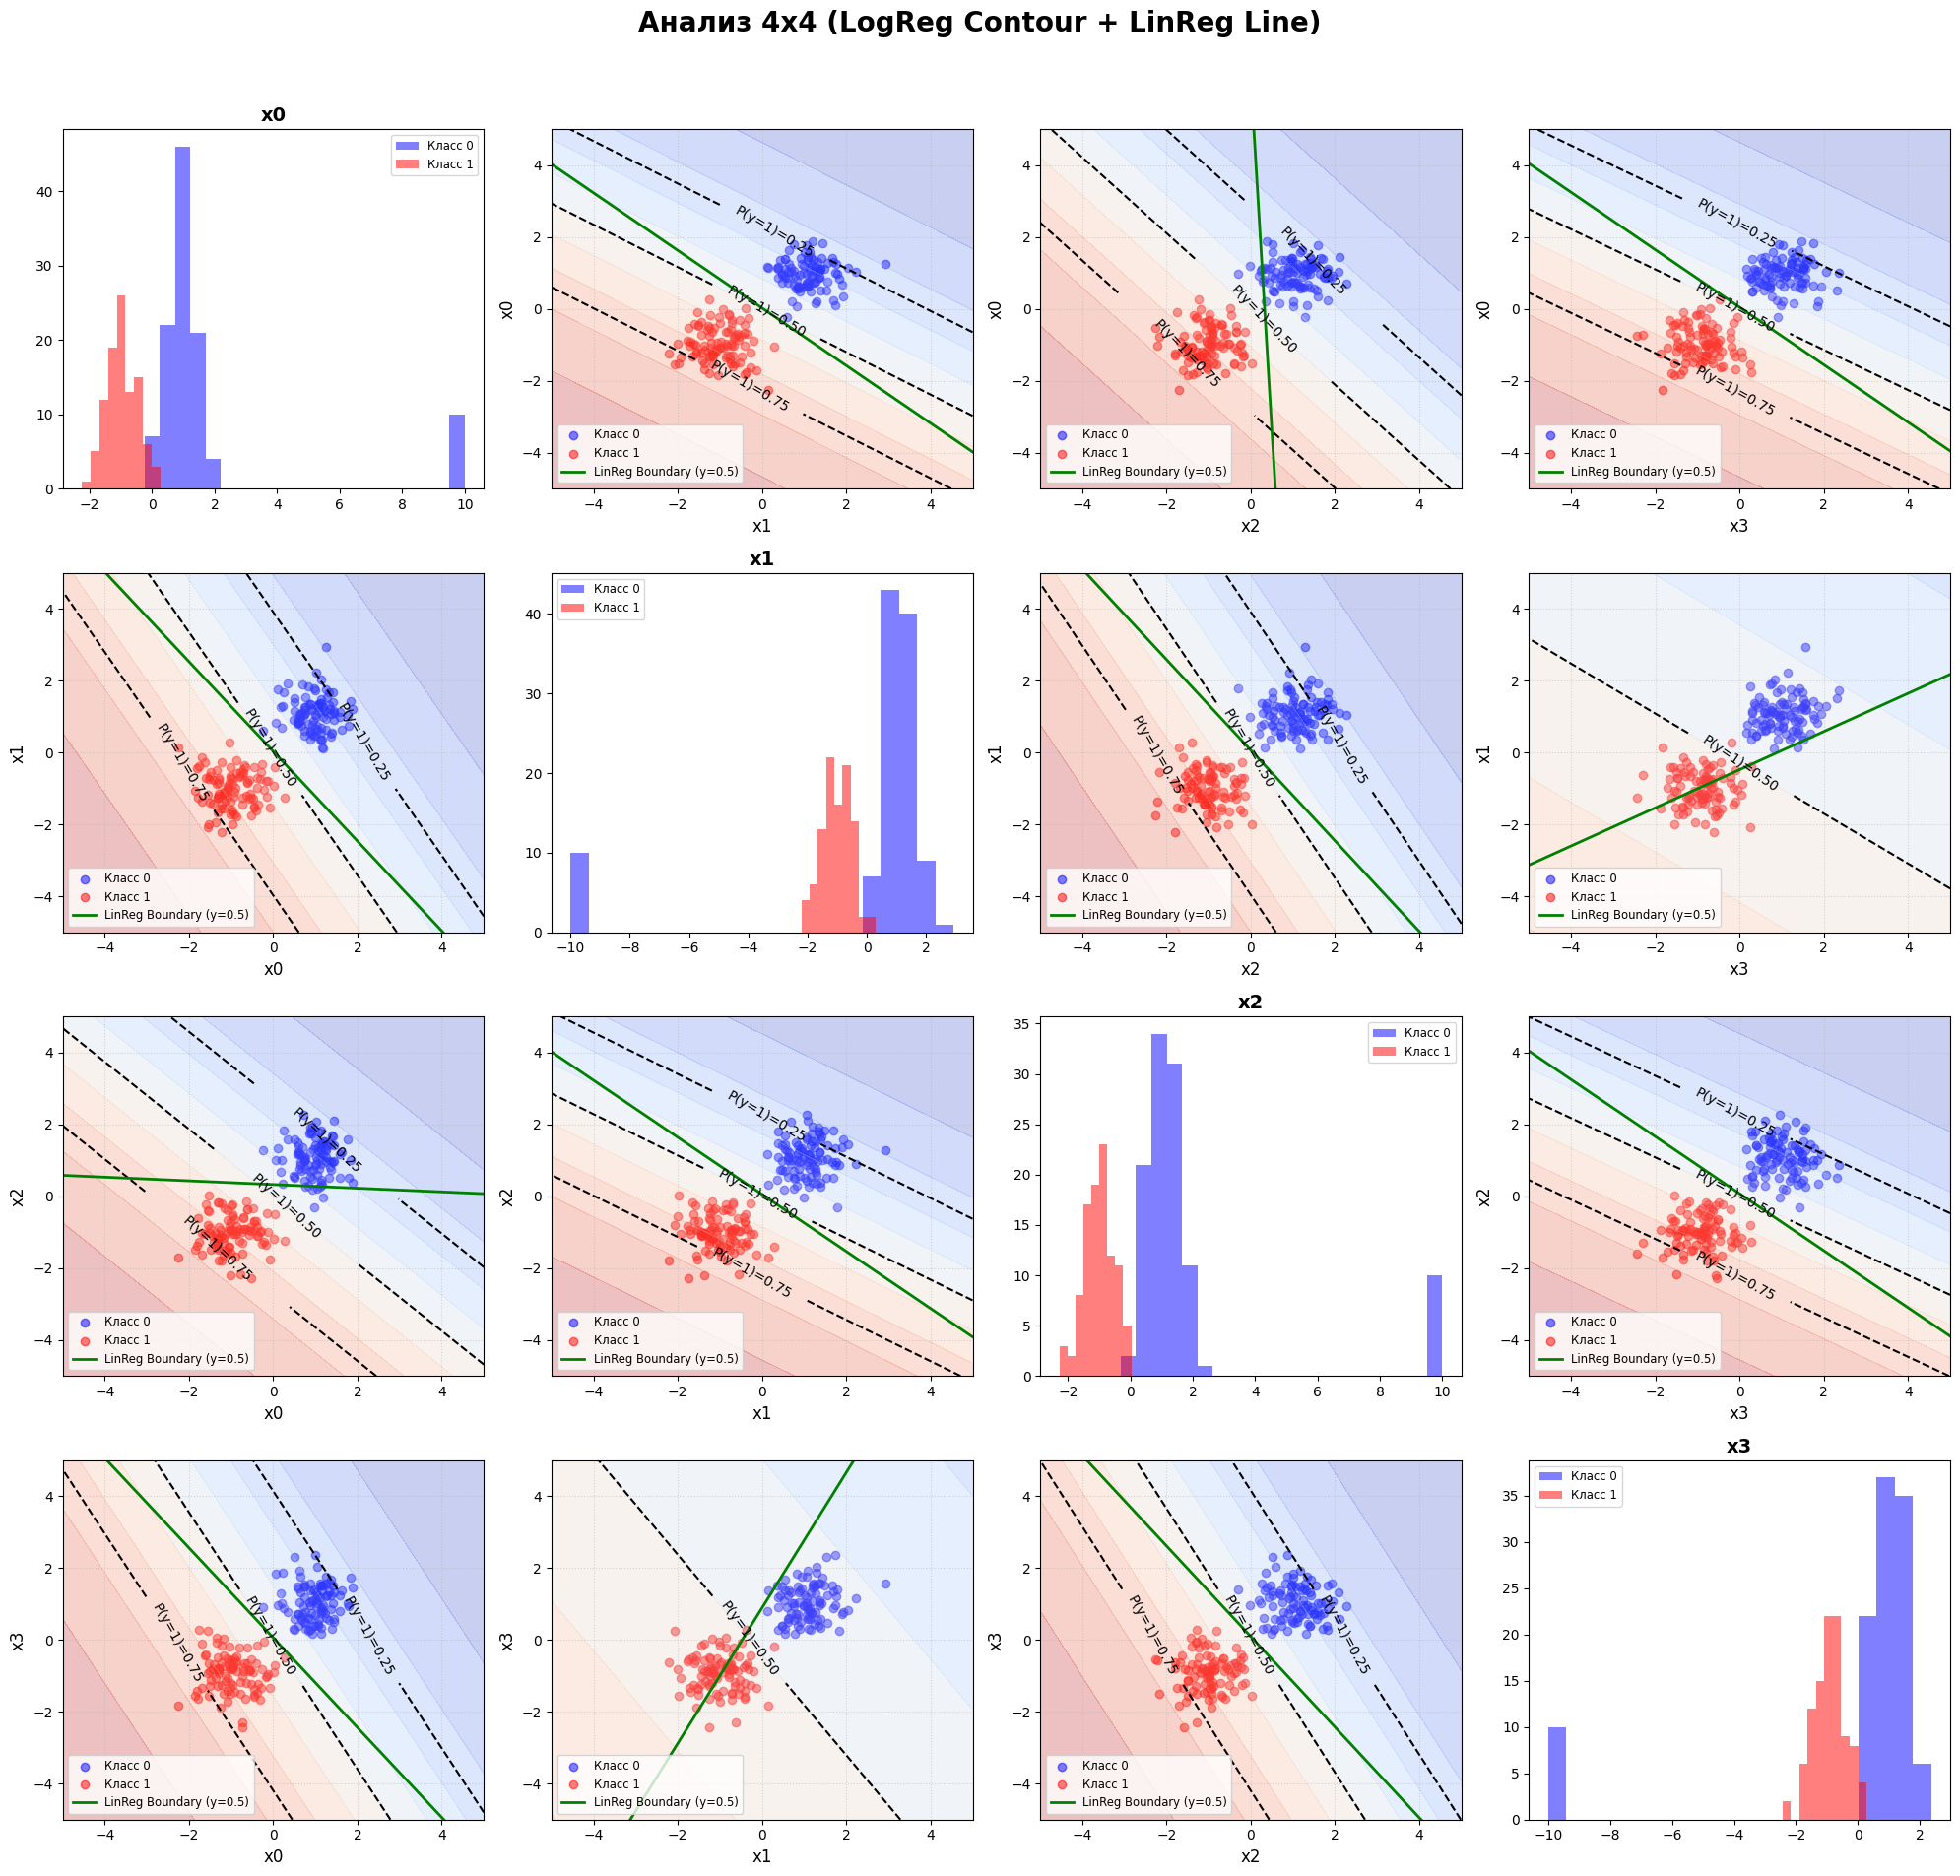

In [153]:
df_to_plot = all_dfs['df_10_10']

task6(
    df_single=df_to_plot,
    features_4d=FEATURES_4D,
    classes_to_analyze=CLASSES_TO_ANALYZE,
    positive_class=POSITIVE_CLASS
)